In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib.axes import Axes
import matplotlib.dates as mdates
import string
from scipy.stats import binom, wilcoxon
import scipy
import matplotlib.cm as cm
from matplotlib.colors import Normalize

### HPV

In [2]:
ww_data_hpv_all = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_flux.csv', sep=";")
ww_data_hpv_all.dateStart = pd.to_datetime(ww_data_hpv_all.dateStart)
ww_data_hpv_all.inhibition *= 100

ww_data_hpv_phages = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_crAssphages.csv', sep=";")
ww_data_hpv_phages.dateStart = pd.to_datetime(ww_data_hpv_phages.dateStart)
ww_data_hpv_phages.inhibition *= 100

ww_data_hpv_mtDNA = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_mtDNA.csv', sep=";")
ww_data_hpv_mtDNA.dateStart = pd.to_datetime(ww_data_hpv_mtDNA.dateStart)
ww_data_hpv_mtDNA.inhibition *= 100

ww_data_hpv_conc = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_ratio_conc.csv', sep=";")
ww_data_hpv_conc.dateStart = pd.to_datetime(ww_data_hpv_conc.dateStart)
ww_data_hpv_conc.inhibition *= 100

In [3]:
def add_lineplot(ax: Axes, letter: str, df: pd.DataFrame, x_axis: str, y_axis: str, label: str, color: str) -> None:
    ax[letter].plot(df[x_axis].values, df[y_axis].values, label=label, color=color, linewidth=10, zorder=3)
    ax[letter].plot(df[x_axis].values, df[y_axis].values, color='black', linewidth=3, zorder=3)    

def add_CI(ax: Axes, letter: str, df: pd.DataFrame, x_axis: str, CIL: str, CIU: str, label: str, color:str, alpha=.3) -> None:
    ax[letter].fill_between(df[x_axis].values, df[CIL].values, df[CIU].values, color=color, label=label, alpha=alpha)

def add_scatter(ax, letter, df, x_axis, y_axis, label, size=520, 
                linewidth=1.5, cmap_feature=None, use_cmap=False,
                color='orange', cmap='bwr', edgecolor='black',
                vmin=0, vmax=1, # normalizer for color bars
                zorder=3):
    
    if use_cmap:
        return ax[letter].scatter(df[x_axis].values, df[y_axis].values, label=label, 
                             c=df[cmap_feature].values,
                             cmap=cmap, edgecolor=edgecolor, s=size, zorder=zorder,
                             linewidth=linewidth, alpha=0.9, vmin=vmin, vmax=vmax)
    else:
        return ax[letter].scatter(df[x_axis].values, df[y_axis].values, label=label, 
                             color=color, edgecolor=edgecolor, s=size, zorder=zorder,
                             linewidth=linewidth, alpha=0.9, vmin=0, vmax=1)        

def recurring_block_plot(letter, df, inhib=True):

    scatter_points_2=None
    add_CI(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', CIL='ICL', CIU='ICU', label='95% CI', color='green', alpha=.3)
    
    scatter_points = add_scatter(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='obs',
                label='Measurements', size=520/4, cmap_feature='pout', use_cmap=True, linewidth=1)

    lod_points = add_scatter(ax=ax_dict, letter=letter, df=df.loc[df.obs<=df.lod], x_axis='dateStart',
                             y_axis='obs', color='None', edgecolor='red', size=640/4, zorder=2, linewidth=5,
                             label='Measurements $\leq$ LoD')

    loq_points = add_scatter(ax=ax_dict, letter=letter, df=df.loc[(df.obs<=df.loq)&(df.obs>df.lod)],
                             x_axis='dateStart', y_axis='obs', color='None', edgecolor='orange', size=640/4, zorder=2, linewidth=5,
                             label='Measurements $\leq$ LoQ')

    if inhib:
        scatter_points_2 = add_scatter(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='obs',
                    label=None, vmin=0, vmax=100, size=240/6, linewidth=0.5, cmap_feature='inhibition', use_cmap=True, cmap='cool')

    add_lineplot(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='muX', label='Smoothed_signal', color='green')
    
    return scatter_points, scatter_points_2, lod_points, loq_points

def assign_labels(ax, letter, xlabel, ylabel, title=None, display_title=False, xrotation=35):
    ax[letter].set_ylabel(ylabel)
    ax[letter].set_xlabel(xlabel)
    ax[letter].tick_params(axis='x', labelsize=TICK_SIZE, rotation=xrotation)
    ax[letter].tick_params(axis='y', labelsize=TICK_SIZE)
    ax[letter].grid(linewidth=1, color='black', alpha=0.8)
    if display_title:
        ax[letter].set_title(title, size=TITLE_SIZE)
    ax[letter].xaxis.set_major_locator(mdates.MonthLocator())

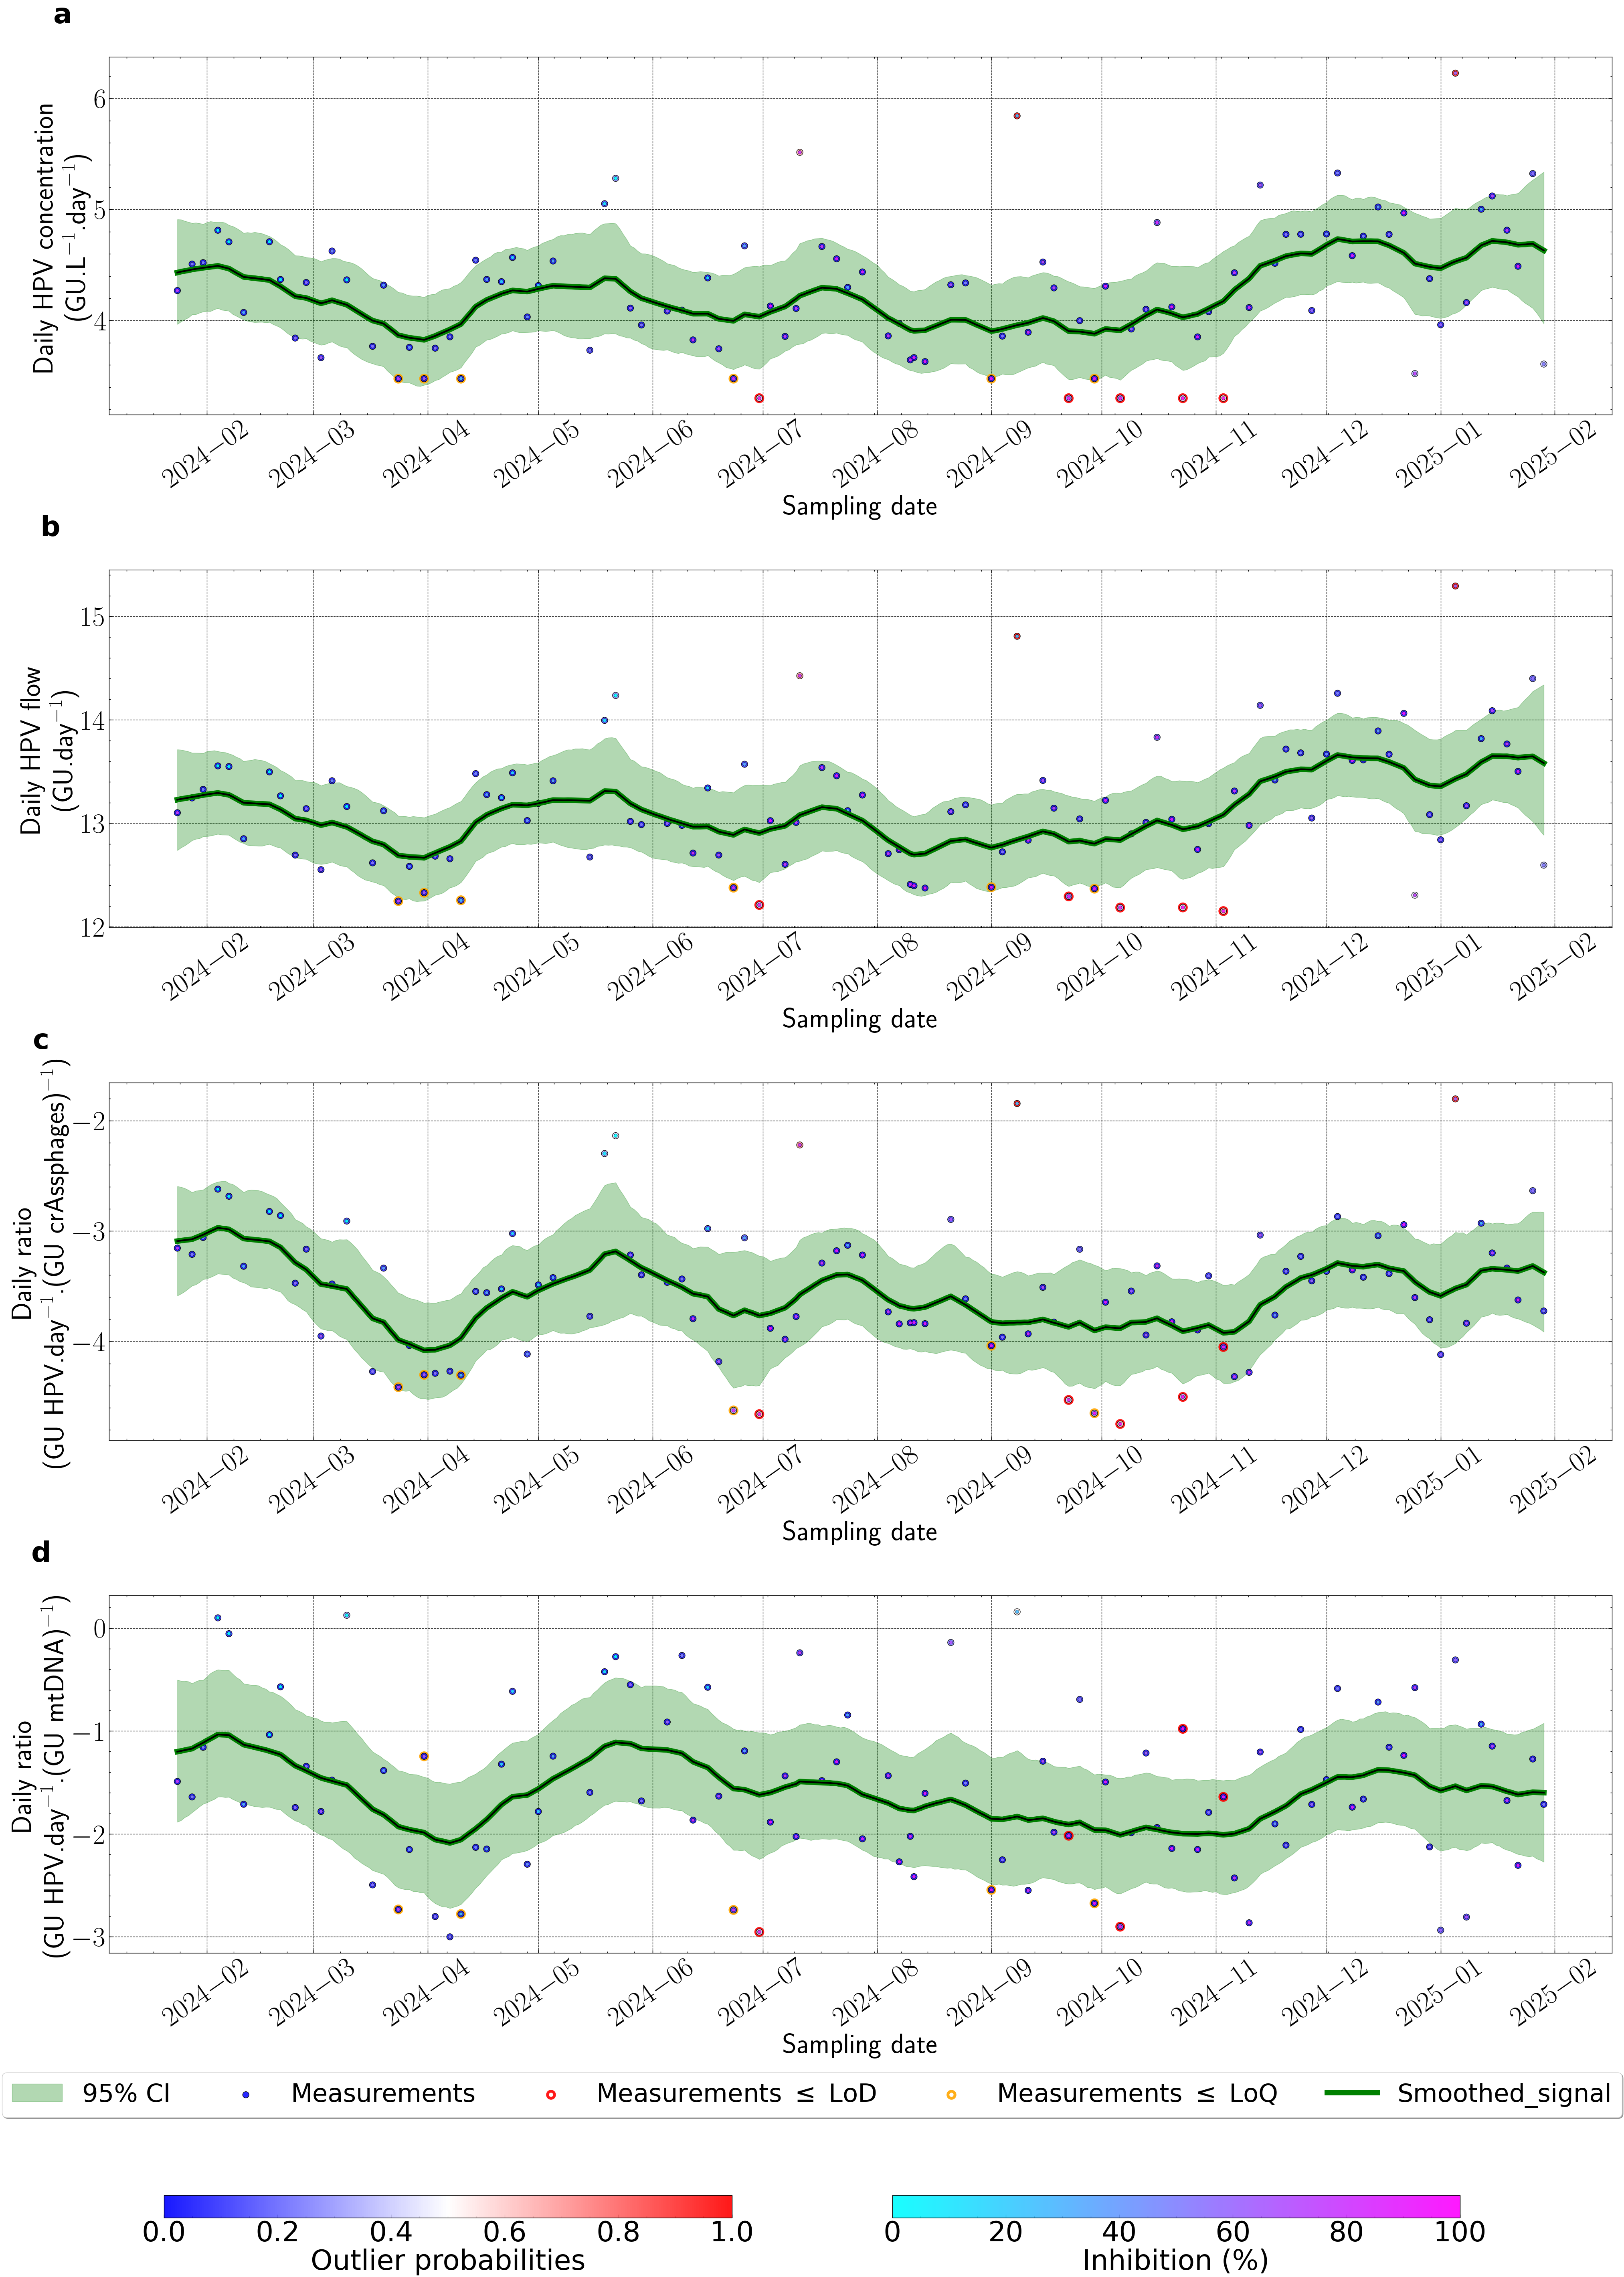

In [4]:
with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1.25#0.875
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (40, 50) #figsize = (34, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        B
        C
        D
        """,
        gridspec_kw={'wspace': 0.05, 'hspace':0.1}
    )
    
    ######################################################### B ######################################################### 
    this_key = 'A'
    sub_data = ww_data_hpv_conc.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV concentration\n (GU.L$^{-1}$.day$^{-1}$)', title='HPV HF - Concentration')   
    ######################################################### B ######################################################### 
    this_key = 'B'
    sub_data = ww_data_hpv_all.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV flow\n (GU.day$^{-1}$)', title='HPV HF - Flow')
    ######################################################### C ######################################################### 
    this_key = 'C'
    sub_data = ww_data_hpv_phages.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily ratio\n (GU HPV.day$^{-1}$.(GU crAssphages)$^{-1}$)',
                  title='HPV HF - crAssphages ratio')
    ######################################################### D ######################################################### 
    this_key = 'D'
    sub_data = ww_data_hpv_mtDNA.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily ratio\n (GU HPV.day$^{-1}$.(GU mtDNA)$^{-1}$)',
                  title='HPV HF - mtDNA ratio')

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    legend = fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)
    
    # === Calcul de la position réelle de la légende ===
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    inv = fig.transFigure.inverted()
    bbox = inv.transform_bbox(bbox)
    
    # === Ajout des deux barres de couleur horizontales épaisses sous la légende ===
    bar_width = 0.8 * bbox.width
    bar_height = 0.5 * bbox.height  # épaisseur importante pour bien voir le dégradé
    bar_x = bbox.x0 + (bbox.width - bar_width) / 2
    bar_y = bbox.y0 - 0.05  # distance entre la légende et les barres

    ecart = 0.05
    # Première colorbar (Outlier probabilities)
    cax1 = fig.add_axes([bar_x, bar_y, bar_width / 2 - ecart, bar_height])
    cax1.grid(False)
    cbar1 = fig.colorbar(scatter_points, cax=cax1, orientation='horizontal')
    cbar1.set_label('Outlier probabilities', size=TICK_SIZE, labelpad=3)
    cbar1.ax.tick_params(labelsize=TICK_SIZE)
    
    # Deuxième colorbar (Inhibition)
    cax2 = fig.add_axes([bar_x + bar_width / 2 + ecart, bar_y, bar_width / 2 - ecart, bar_height])
    cax2.grid(False)
    cbar2 = fig.colorbar(scatter_points_2, cax=cax2, orientation='horizontal')
    cbar2.set_label('Inhibition (%)', size=TICK_SIZE, labelpad=3)
    cbar2.ax.tick_params(labelsize=TICK_SIZE)

    # Letters
    # Display subplot keys
    plt.rcParams['text.usetex'] = False
    
    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig, offset=0.175):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + offset, text.lower(), ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        align_text_with_ylabel(ax, key, fig, offset=0.110)
    
    plt.savefig("../outputs/figs/" + 'HPV_HF_0109' + ".pdf", bbox_inches = 'tight')
    
    plt.show()

### HPV 6

In [5]:
ww_data_hpv_6_conc = pd.read_csv('../outputs/files/3010/HPV_6_2025-10-30_ratio_conc.csv', sep=";")
ww_data_hpv_6_conc.dateStart = pd.to_datetime(ww_data_hpv_6_conc.dateStart)

ww_data_hpv_6_all = pd.read_csv('../outputs/files/3010/HPV_6_2025-10-30_ratio_flux.csv', sep=";")
ww_data_hpv_6_all.dateStart = pd.to_datetime(ww_data_hpv_6_all.dateStart)

ww_data_hpv_6_phages = pd.read_csv('../outputs/files/3010/HPV_6_2025-10-30_ratio_crAssphages.csv', sep=";")
ww_data_hpv_6_phages.dateStart = pd.to_datetime(ww_data_hpv_6_phages.dateStart)

ww_data_hpv_6_mtDNA = pd.read_csv('../outputs/files/3010/HPV_6_2025-10-30_ratio_mtDNA.csv', sep=";")
ww_data_hpv_6_mtDNA.dateStart = pd.to_datetime(ww_data_hpv_6_mtDNA.dateStart)

ww_data_hpv_66_conc = pd.read_csv('../outputs/files/3010/HPV_66_2025-10-30_ratio_conc.csv', sep=";")
ww_data_hpv_66_conc.dateStart = pd.to_datetime(ww_data_hpv_66_conc.dateStart)

ww_data_hpv_66_all = pd.read_csv('../outputs/files/3010/HPV_66_2025-10-30_ratio_flux.csv', sep=";")
ww_data_hpv_66_all.dateStart = pd.to_datetime(ww_data_hpv_66_all.dateStart)

ww_data_hpv_66_phages = pd.read_csv('../outputs/files/3010/HPV_66_2025-10-30_ratio_crAssphages.csv', sep=";")
ww_data_hpv_66_phages.dateStart = pd.to_datetime(ww_data_hpv_66_phages.dateStart)

ww_data_hpv_66_mtDNA = pd.read_csv('../outputs/files/3010/HPV_66_2025-10-30_ratio_mtDNA.csv', sep=";")
ww_data_hpv_66_mtDNA.dateStart = pd.to_datetime(ww_data_hpv_66_mtDNA.dateStart)

In [6]:
def add_lineplot(ax: Axes, letter: str, df: pd.DataFrame, x_axis: str, y_axis: str, label: str, color: str) -> None:
    ax[letter].plot(df[x_axis].values, df[y_axis].values, label=label, color=color, linewidth=10, zorder=3)
    ax[letter].plot(df[x_axis].values, df[y_axis].values, color='black', linewidth=3, zorder=3)    

def add_CI(ax: Axes, letter: str, df: pd.DataFrame, x_axis: str, CIL: str, CIU: str, label: str, color:str, alpha=.3) -> None:
    ax[letter].fill_between(df[x_axis].values, df[CIL].values, df[CIU].values, color=color, label=label, alpha=alpha)

def add_scatter(ax, letter, df, x_axis, y_axis, label, size=520, 
                linewidth=1.5, cmap_feature=None, use_cmap=False,
                color='orange', cmap='bwr', edgecolor='black',
                vmin=0, vmax=1, # normalizer for color bars
                zorder=3):
    
    if use_cmap:
        return ax[letter].scatter(df[x_axis].values, df[y_axis].values, label=label, 
                             c=df[cmap_feature].values,
                             cmap=cmap, edgecolor=edgecolor, s=size, zorder=zorder,
                             linewidth=linewidth, alpha=0.9, vmin=vmin, vmax=vmax)
    else:
        return ax[letter].scatter(df[x_axis].values, df[y_axis].values, label=label, 
                             color=color, edgecolor=edgecolor, s=size, zorder=zorder,
                             linewidth=linewidth, alpha=0.9, vmin=0, vmax=1)        

def recurring_block_plot(letter, df, inhib=True):

    scatter_points_2=None
    add_CI(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', CIL='ICL', CIU='ICU', label='95% CI', color='green', alpha=.3)
    
    scatter_points = add_scatter(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='obs',
                label='Measurements', size=520/4, cmap_feature='pout', use_cmap=True, linewidth=1.0)

    lod_points = add_scatter(ax=ax_dict, letter=letter, df=df.loc[df.obs<=df.lod], x_axis='dateStart',
                             y_axis='obs', color='None', edgecolor='red', size=640/4, zorder=2, linewidth=5,
                             label='Measurements $\leq$ LoD')

    loq_points = add_scatter(ax=ax_dict, letter=letter, df=df.loc[(df.obs<=df.loq)&(df.obs>df.lod)],
                             x_axis='dateStart', y_axis='obs', color='None', edgecolor='orange', size=640/4, zorder=2, linewidth=5,
                             label='Measurements $\leq$ LoQ')

    if inhib:
        scatter_points_2 = add_scatter(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='obs',
                    label=None, vmin=0, vmax=100, size=240, cmap_feature='inhibition', use_cmap=True, cmap='cool')

    add_lineplot(ax=ax_dict, letter=letter, df=df, x_axis='dateStart', y_axis='muX', label='Smoothed_signal', color='green')
    
    return scatter_points, scatter_points_2, lod_points, loq_points

def assign_labels(ax, letter, xlabel, ylabel, title=None, display_title=False, xrotation=45):
    ax[letter].set_ylabel(ylabel)
    ax[letter].set_xlabel(xlabel)
    ax[letter].tick_params(axis='x', labelsize=TICK_SIZE, rotation=xrotation)
    ax[letter].tick_params(axis='y', labelsize=TICK_SIZE)
    ax[letter].grid(linewidth=1, color='black', alpha=0.8)
    if display_title:
        ax[letter].set_title(title, size=TITLE_SIZE)
    #ax[letter].xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    ax[letter].xaxis.set_major_locator(mdates.MonthLocator())

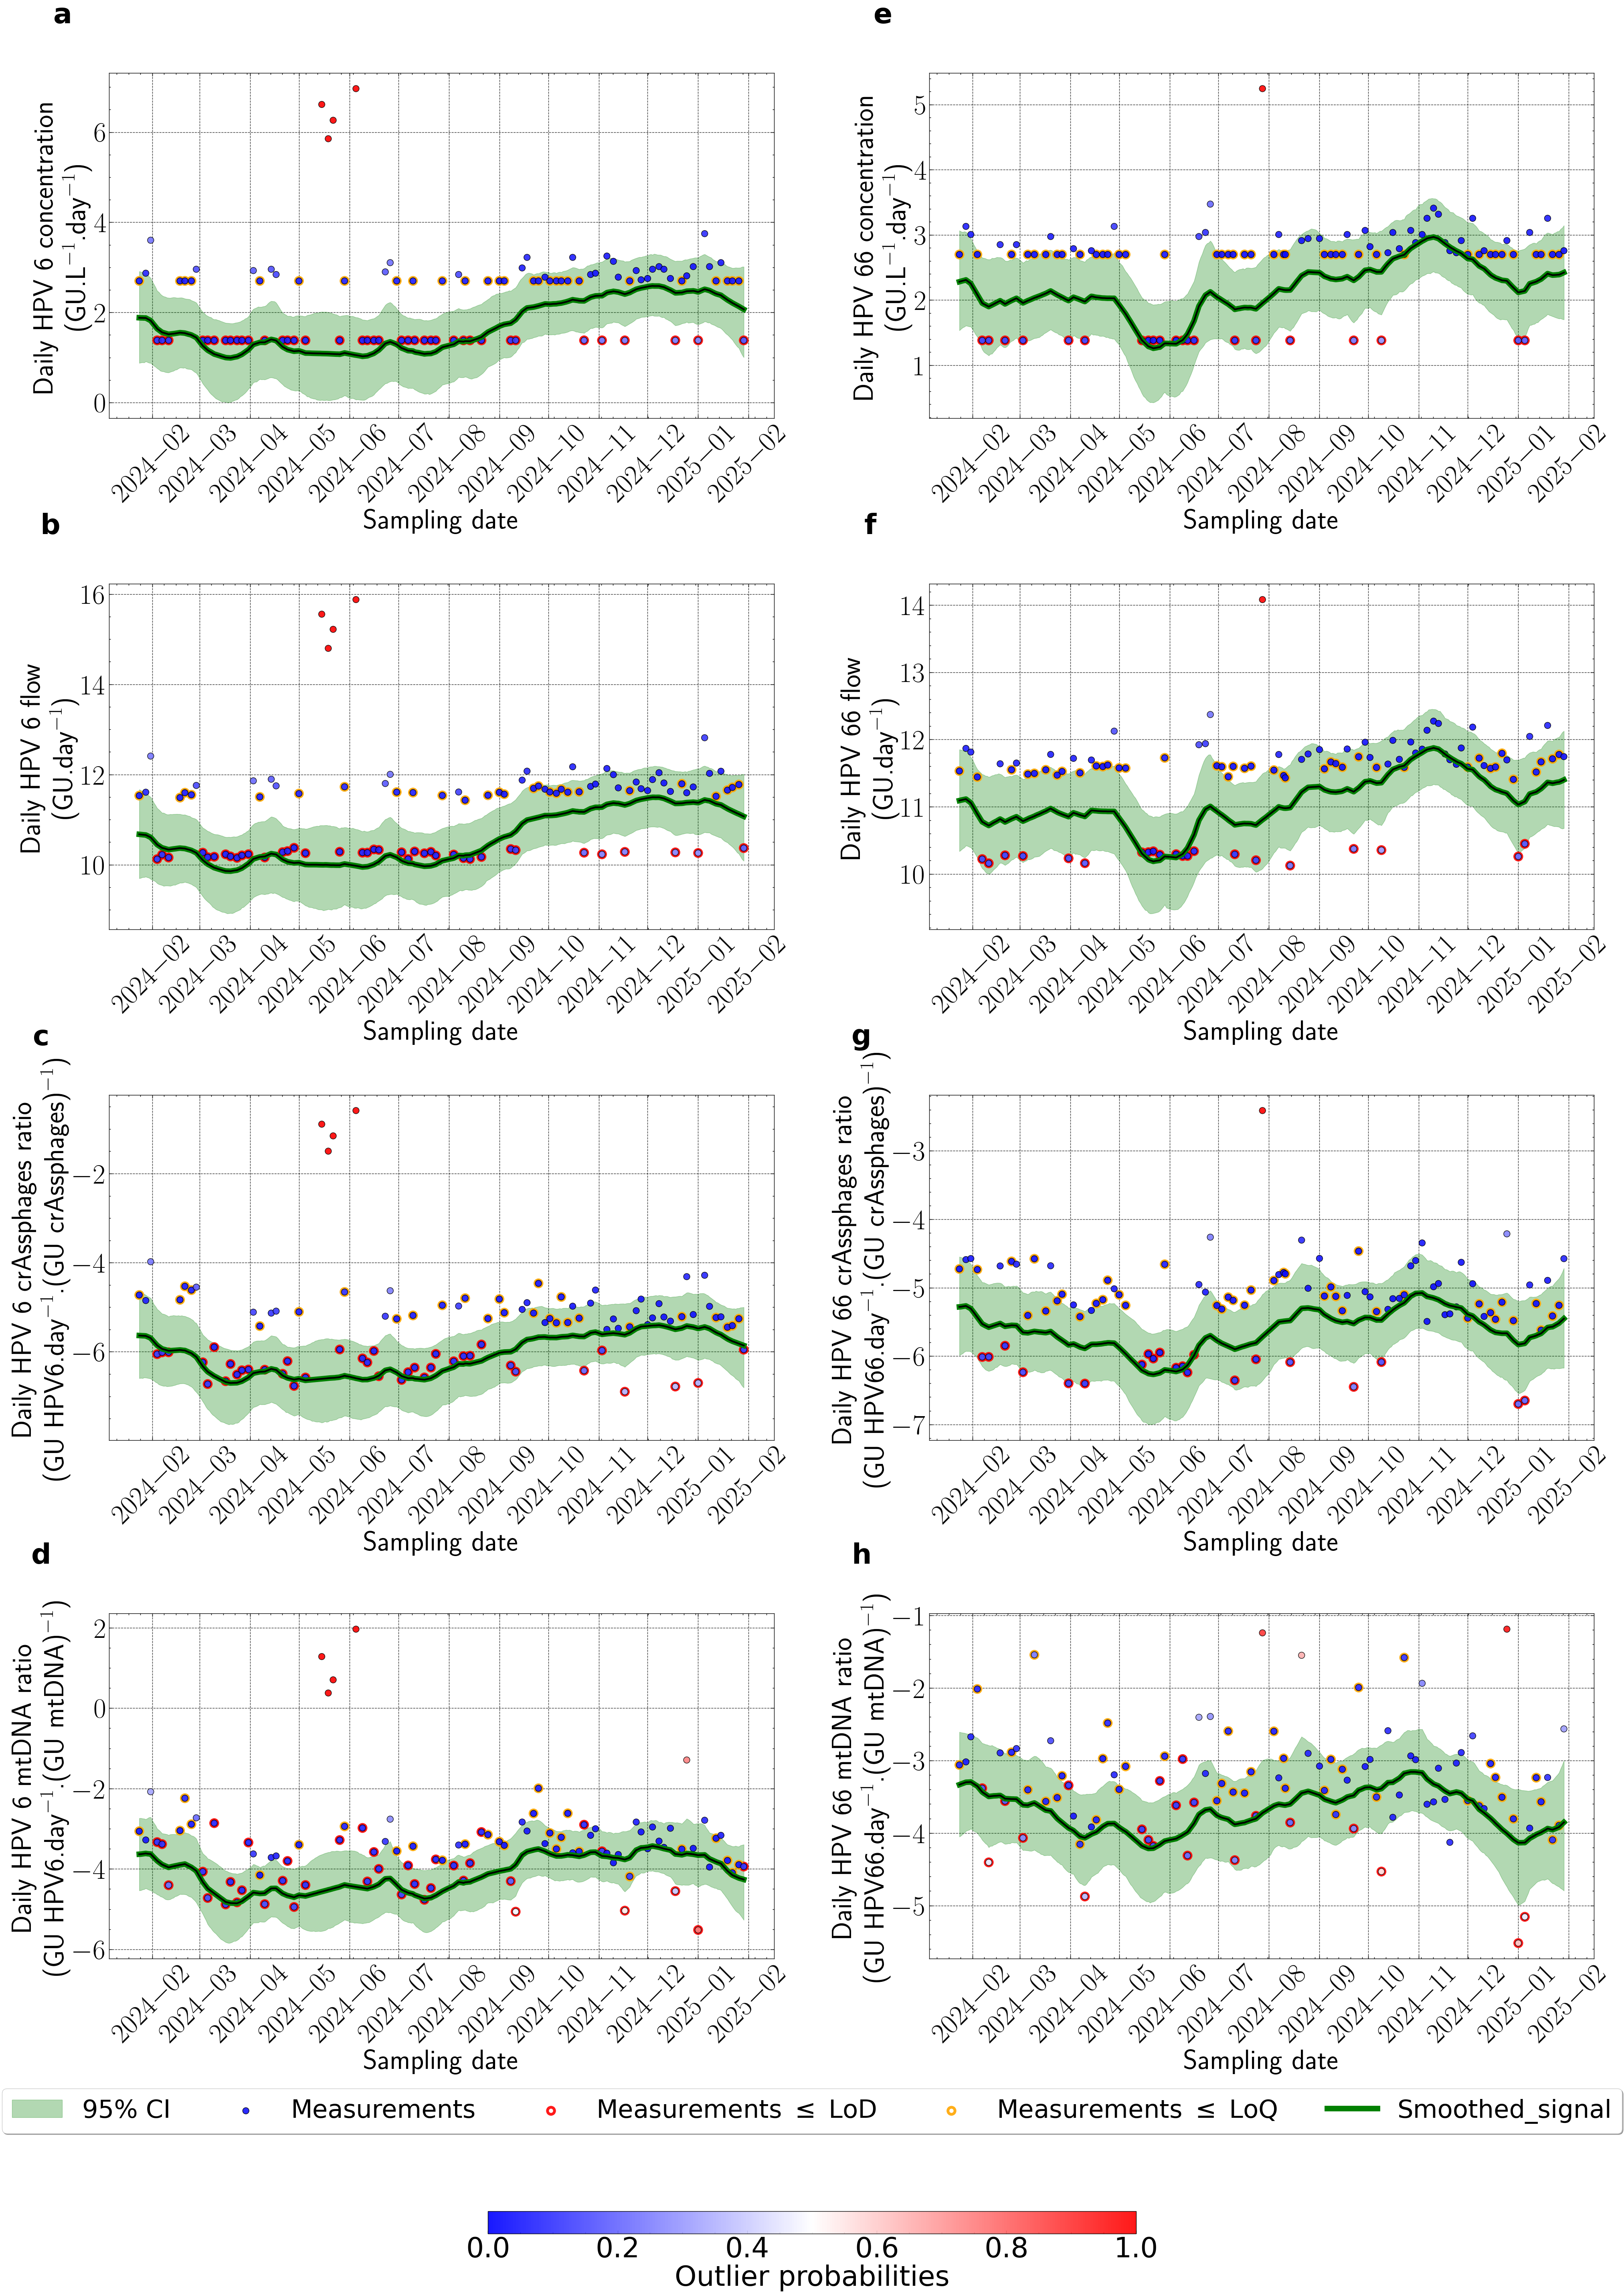

In [7]:
with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1.25#0.875
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (40, 50) #figsize = (34, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        AE
        BF
        CG
        DH
        """,
        gridspec_kw={'wspace': 0.05, 'hspace':0.1}
    )
    
    ######################################################### A ######################################################### 
    this_key = 'A'
    sub_data = ww_data_hpv_6_conc.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 6 concentration\n (GU.L$^{-1}$.day$^{-1}$)', title='HPV 6 - Concentration')   
    ######################################################### B ######################################################### 
    this_key = 'B'
    sub_data = ww_data_hpv_6_all.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 6 flow\n (GU.day$^{-1}$)', title='HPV 6 - Flux')
    ######################################################### C ######################################################### 
    this_key = 'C'
    sub_data = ww_data_hpv_6_phages.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 6 crAssphages ratio\n (GU HPV6.day$^{-1}$.(GU crAssphages)$^{-1}$)',
                  title='HPV 6 - Phages ratio')
    ######################################################### D ######################################################### 
    this_key = 'D'
    sub_data = ww_data_hpv_6_mtDNA.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 6 mtDNA ratio\n (GU HPV6.day$^{-1}$.(GU mtDNA)$^{-1}$)',
                  title='HPV 6 - mtDNA ratio')


    ######################################################### E ######################################################### 
    this_key = 'E'
    sub_data = ww_data_hpv_66_conc.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 66 concentration\n (GU.L$^{-1}$.day$^{-1}$)', title='HPV 66 - Concentration')   
    ######################################################### F ######################################################### 
    this_key = 'F'
    sub_data = ww_data_hpv_66_all.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 66 flow\n (GU.day$^{-1}$)', title='HPV 66 - Flux')
    ######################################################### G ######################################################### 
    this_key = 'G'
    sub_data = ww_data_hpv_66_phages.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 66 crAssphages ratio\n (GU HPV66.day$^{-1}$.(GU crAssphages)$^{-1}$)',
                  title='HPV 66 - Phages ratio')
    ######################################################### H ######################################################### 
    this_key = 'H'
    sub_data = ww_data_hpv_66_mtDNA.copy()
    scatter_points, scatter_points_2, lod_points, loq_points = recurring_block_plot(this_key, sub_data, inhib=False)
    assign_labels(ax_dict, this_key, xlabel='Sampling date', ylabel='Daily HPV 66 mtDNA ratio\n (GU HPV66.day$^{-1}$.(GU mtDNA)$^{-1}$)',
                  title='HPV 66 - mtDNA ratio')
    

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    legend = fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)
    
    # === Calcul de la position réelle de la légende ===
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    inv = fig.transFigure.inverted()
    bbox = inv.transform_bbox(bbox)
    
    # === Ajout des deux barres de couleur horizontales épaisses sous la légende ===
    bar_width = 0.4 * bbox.width
    bar_height = 0.5 * bbox.height  # épaisseur importante pour bien voir le dégradé
    bar_x = bbox.x0 + (bbox.width - bar_width) / 2
    bar_y = bbox.y0 - 0.05  # distance entre la légende et les barres

    ecart = 0.05
    # Première colorbar (Outlier probabilities)
    cax1 = fig.add_axes([bar_x, bar_y, bar_width, bar_height])
    cax1.grid(False)
    cbar1 = fig.colorbar(scatter_points, cax=cax1, orientation='horizontal')
    cbar1.set_label('Outlier probabilities', size=TICK_SIZE, labelpad=3)
    cbar1.ax.tick_params(labelsize=TICK_SIZE)

    
    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig, offset=0.175):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + offset, text.lower(), ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        align_text_with_ylabel(ax, key, fig, offset=0.115)

    plt.savefig("../outputs/figs/" + 'HPV_6_66_0109' + ".pdf", bbox_inches = 'tight')
    
    plt.show()

### Differences between sample 1 & 2 distributions

In [8]:
filepath = '../data/HPV 66 et 6.xlsx'

data_HPV6 = pd.read_excel(filepath, sheet_name='HPV 6')
data_HPV6 = data_HPV6.iloc[:, [1, 2, 3]]
data_HPV6 = data_HPV6.loc[1:]
data_HPV6.columns = ['dateStart', 'obs_R1', 'obs_R2']

# Manual inputs for dateStart
data_HPV6.dateStart = data_HPV6.dateStart.replace('03/07/2024', '2024-07-03')
data_HPV6.dateStart = data_HPV6.dateStart.replace('01/09/2024', '2024-09-01')
data_HPV6.dateStart = data_HPV6.dateStart.replace('04/09/2024', '2024-09-04')
data_HPV6.dateStart = data_HPV6.dateStart.replace('10/08/2024', '2024-08-10')
data_HPV6.dateStart = data_HPV6.dateStart.replace('14/08/2024', '2024-08-14')
data_HPV6.dateStart = data_HPV6.dateStart.replace('25/08/2024', '2024-08-25')
data_HPV6.dateStart = data_HPV6.dateStart.replace('03/11/2024', '2024-11-03')
data_HPV6.dateStart = data_HPV6.dateStart.replace('06/11/2024', '2024-11-06')
data_HPV6.dateStart = data_HPV6.dateStart.replace('10/11/2024', '2024-11-10')
data_HPV6.dateStart = data_HPV6.dateStart.replace('01/12/2024', '2024-12-01')
data_HPV6.dateStart = data_HPV6.dateStart.replace('04/12/2024', '2024-12-04')
data_HPV6.dateStart = data_HPV6.dateStart.replace('08/12/2024', '2024-12-08')
data_HPV6.dateStart = data_HPV6.dateStart.replace('05/01/2025', '2025-01-05')

data_HPV6.dateStart = pd.to_datetime(data_HPV6.dateStart)#, format='DD/MM/YYYY')
data_HPV6.obs_R1 = pd.to_numeric(data_HPV6.obs_R1)
data_HPV6.obs_R2 = pd.to_numeric(data_HPV6.obs_R2)
data_HPV6.sort_values(by='dateStart', inplace=True)
data_HPV6.head()

dateStart  obs_R1  obs_R2
1 2024-01-24    39.3    38.9
2 2024-01-28    37.9    36.7
3 2024-01-31    35.4    35.3
4 2024-02-18    40.3    37.8
5 2024-02-21    39.1    41.5

In [9]:
filepath = '../data/HPV 66 et 6.xlsx'

data_HPV66 = pd.read_excel(filepath, sheet_name='HPV 66')
data_HPV66 = data_HPV66.iloc[:, [1, 2, 3]]
data_HPV66 = data_HPV66.loc[1:]
data_HPV66.columns = ['dateStart', 'obs_R1', 'obs_R2']

# Manual inputs for dateStart
data_HPV66.dateStart = data_HPV66.dateStart.replace('03/07/2024', '2024-07-03')
data_HPV66.dateStart = data_HPV66.dateStart.replace('01/09/2024', '2024-09-01')
data_HPV66.dateStart = data_HPV66.dateStart.replace('04/09/2024', '2024-09-04')
data_HPV66.dateStart = data_HPV66.dateStart.replace('10/08/2024', '2024-08-10')
data_HPV66.dateStart = data_HPV66.dateStart.replace('14/08/2024', '2024-08-14')
data_HPV66.dateStart = data_HPV66.dateStart.replace('25/08/2024', '2024-08-25')
data_HPV66.dateStart = data_HPV66.dateStart.replace('03/11/2024', '2024-11-03')
data_HPV66.dateStart = data_HPV66.dateStart.replace('06/11/2024', '2024-11-06')
data_HPV66.dateStart = data_HPV66.dateStart.replace('10/11/2024', '2024-11-10')
data_HPV66.dateStart = data_HPV66.dateStart.replace('01/12/2024', '2024-12-01')
data_HPV66.dateStart = data_HPV66.dateStart.replace('04/12/2024', '2024-12-04')
data_HPV66.dateStart = data_HPV66.dateStart.replace('08/12/2024', '2024-12-08')
data_HPV66.dateStart = data_HPV66.dateStart.replace('05/01/2025', '2025-01-05')

data_HPV66.dateStart = pd.to_datetime(data_HPV66.dateStart)#, format='DD/MM/YYYY')
data_HPV66.obs_R1 = pd.to_numeric(data_HPV66.obs_R1)
data_HPV66.obs_R2 = pd.to_numeric(data_HPV66.obs_R2)
data_HPV66.sort_values(by='dateStart', inplace=True)
data_HPV66.head()

dateStart  obs_R1  obs_R2
1 2024-01-24    40.9    40.4
2 2024-01-28    37.4    42.0
3 2024-01-31    37.8    37.4
4 2024-02-04    41.8    40.0
5 2024-02-18    38.3    37.3

In [10]:
# extending the previous test to all different subtypes:

input_replicate_1 = pd.read_excel("../data/pvalue-HPV.xlsx", sheet_name='Essai 1')
input_replicate_2 = pd.read_excel("../data/pvalue-HPV.xlsx", sheet_name='Essai 2')

In [11]:
def process_replicate(input_replicate, this_type):

    subcols = ['Date', this_type]
    sub_replicate = input_replicate.loc[::, subcols]
    sub_replicate = sub_replicate.loc[~sub_replicate.Date.isna()]
    
    original_date = ['03/07/2024', '10/08/2024', '14/08/2024',
                    '03/11/2024', '06/11/2024', '10/11/2024',
                    '25/08/2024', '01/09/2024', '04/09/2024',
                    '18/09/2024', '16/10/2024', '01/12/2024',
                    '04/12/2024', '08/12/2024', '01/01/2025',
                    '05/01/2025'
                     ]
    
    modified_date = ['2024-07-03 00:00:00', '2024-08-10 00:00:00', '2024-08-14 00:00:00',
                     '2024-11-03 00:00:00', '2024-11-06 00:00:00', '2024-11-10 00:00:00',
                     '2024-08-25 00:00:00', '2024-09-01 00:00:00', '2024-09-04 00:00:00',
                     '2024-09-18 00:00:00', '2024-10-16 00:00:00', '2024-12-01 00:00:00',
                     '2024-12-04 00:00:00', '2024-12-08 00:00:00', '2025-01-01 00:00:00',
                     '2025-01-05 00:00:00']
    
    for date_index, date in enumerate(original_date):
        sub_replicate.Date = sub_replicate.Date.replace(date, modified_date[date_index])
    
    sub_replicate.Date = pd.to_datetime(sub_replicate.Date)

    # dealing with 2024-08-21 duplicates
    duplicate_indexes = sub_replicate.loc[sub_replicate.Date=='2024-08-21'].index.values
    
    if sub_replicate.loc[(sub_replicate.Date=='2024-08-21')&(~sub_replicate[this_type].isna())].shape[0]==2:
        sub_replicate.drop(duplicate_indexes[-1], axis=0, inplace=True)

    elif sub_replicate.loc[(sub_replicate.Date=='2024-08-21')&(~sub_replicate[this_type].isna())].shape[0]==0:
        sub_replicate.drop(duplicate_indexes[-1], axis=0, inplace=True)

    elif sub_replicate.loc[(sub_replicate.Date=='2024-08-21')&(~sub_replicate[this_type].isna())].shape[0]==1:
        this_index = sub_replicate.loc[(sub_replicate.Date=='2024-08-21')&(~sub_replicate[this_type].isna())].index.tolist()[0]
        dropme = duplicate_indexes[np.where(duplicate_indexes!=this_index)[0][0]]
        sub_replicate.drop(dropme, axis=0, inplace=True)

    sub_replicate = sub_replicate.rename(columns={'Date':'dateStart'})
    sub_replicate.set_index('dateStart', inplace=True)
    
    return sub_replicate

In [12]:
def join_and_get_samples(this_type):
    
    sr1_6 = process_replicate(input_replicate_1, this_type)
    sr2_6 = process_replicate(input_replicate_2, this_type)

    sr_6 = sr1_6.join(sr2_6, lsuffix='_1', rsuffix='_2')
    sr_6 = sr_6.loc[(~sr_6.iloc[:,0].isna()) & (~sr_6.iloc[:,1].isna())]

    sample_1 = sr_6.iloc[:,0].values
    sample_2 = sr_6.iloc[:,1].values

    return sample_1, sample_2

In [13]:
letters = list(string.ascii_uppercase)
letters.append('0')
letters.append('1')
letter_type_dict = {}

for letter_index, letter in enumerate(letters):
    letter_type_dict[letter] = input_replicate_1.columns[3:].tolist()[letter_index]


In [14]:
colors = ['dodgerblue', 'crimson']
replicates = ['Replicate 1', 'Replicate 2']

In [15]:
def get_table(this_type):
    
    sr1_6 = process_replicate(input_replicate_1, this_type)
    sr2_6 = process_replicate(input_replicate_2, this_type)

    sr_6 = sr1_6.join(sr2_6, lsuffix='_1', rsuffix='_2')

    contigency_table = np.zeros((2, 2))
    contigency_table[0,0] = sr_6.loc[(~sr_6.iloc[:,0].isna()) & (~sr_6.iloc[:,1].isna())].shape[0]
    contigency_table[1,1] = sr_6.loc[(sr_6.iloc[:,0].isna()) & (sr_6.iloc[:,1].isna())].shape[0]
    contigency_table[0,1] = sr_6.loc[(~sr_6.iloc[:,0].isna()) & (sr_6.iloc[:,1].isna())].shape[0]
    contigency_table[1,0] = sr_6.loc[(sr_6.iloc[:,0].isna()) & (~sr_6.iloc[:,1].isna())].shape[0]

    return contigency_table


In [16]:
def f_(x_12, n):
    output = scipy.special.binom(n, x_12) * (1/2) ** n
    return output

In [17]:
def ospv(b, n):
    output = 0
    for k in range(b+1):
        output += f_(k, n)

    return output

In [18]:
def mid_p_test(d1, d2):
    b = min(d1, d2)
    b_c = d1 + d2

    res = 2*binom.cdf(b, b_c, 0.5) - binom.pmf(b, b_c, 0.5)
    one_sided_pval = ospv(b, b_c)
    res0 = 2*one_sided_pval - f_(b, b_c)
    return res, res0, np.allclose(res, res0)

In [19]:
# just checking that both approaches yield the same results

d1 = 26
d2 = 0

mid_p_test(d1, d2)

(1.4901161193847653e-08, 1.4901161193847656e-08, True)

In [20]:
def mid_p_test(d1, d2):
    b = min(d1, d2)
    b_c = d1 + d2

    res = 2*binom.cdf(b, b_c, 0.5) - binom.pmf(b, b_c, 0.5)
    one_sided_pval = ospv(b, b_c)
    res0 = 2*one_sided_pval - f_(b, b_c)
    return res0

In [21]:
table_per_type = {}

for this_type in input_replicate_1.columns[3:].tolist():
    table_per_type[this_type] = get_table(this_type)

In [22]:
test_result_dict = {}

for this_type in input_replicate_1.columns[3:].tolist():
    exact = False
    correction = True
    
    this_table = table_per_type[this_type]
    b, c = int(this_table[0,1]), int(this_table[1,0])
    pvalue = mid_p_test(b, c)
    
    test_result_dict[this_type] = pvalue, b+c

test_result_dict

{'HPV 6': (0.21532714972272515, 31),
 'HPV 11': (0.18924713134765625, 20),
 'HPV 16': (0.803619384765625, 15),
 'HPV 18': (0.375, 4),
 'HPV 26': (0.0625, 4),
 'HPV 31': (1.0, 2),
 'HPV 33': (1.0, 4),
 'HPV 35': (0.7265625, 7),
 'HPV 39': (0.10812902140605729, 38),
 'HPV 40': (0.057373046875, 13),
 'HPV 42': (0.8714146793645341, 37),
 'HPV 43': (0.013852965261321515, 37),
 'HPV 44': (0.454498291015625, 15),
 'HPV 45': (1.0, 10),
 'HPV 51': (0.125, 3),
 'HPV 52': (0.25, 2),
 'HPV 53': (0.8318119049072266, 21),
 'HPV 54': (0.11846923828125, 14),
 'HPV 56': (0.5327092552361137, 40),
 'HPV 58': (0.125, 3),
 'HPV 59': (0.04138946533203125, 19),
 'HPV 61': (1.0, 0),
 'HPV 66': (0.6476058959960938, 18),
 'HPV 68': (0.7011080384254456, 26),
 'HPV 69': (0.2890625, 7),
 'HPV 70': (0.7265625, 7),
 'HPV 73': (0.001878225477412343, 34),
 'HPV 82': (0.03125, 5)}

In [23]:
kept_types = []

for this_letter in letters:
    this_type = letter_type_dict[this_letter]
    sample_1, sample_2 = join_and_get_samples(this_type)

    # perform statistical testing only if a sufficient number of samples is available:
    if sample_1.shape[0] < 2 or sample_2.shape[0] < 2:
        continue

    kept_types.append(this_type)

kept_types

['HPV 6',
 'HPV 11',
 'HPV 16',
 'HPV 39',
 'HPV 42',
 'HPV 43',
 'HPV 44',
 'HPV 53',
 'HPV 56',
 'HPV 59',
 'HPV 66',
 'HPV 68',
 'HPV 73']

In [24]:
letter_type_dict = {}

for type_index, this_type in enumerate(kept_types):
    letter_type_dict[letters[type_index]] = this_type


In [25]:
def create_dataframe(this_type):
    sr1_6 = process_replicate(input_replicate_1, this_type)
    sr2_6 = process_replicate(input_replicate_2, this_type)
    
    sr_6 = sr1_6.join(sr2_6, lsuffix='_1', rsuffix='_2')
    for column in sr_6.columns.tolist():
        sr_6[column].replace(" NA", np.nan, inplace=True)
        sr_6[column].replace("NA ", np.nan, inplace=True)
        sr_6[column] = pd.to_numeric(sr_6[column])
    toto = sr_6.fillna(43.0)

    sample_1 = toto.iloc[:, 0].astype(float)
    sample_2 = toto.iloc[:, 1].astype(float)
    
    censored_1 = [False if el <43 else True for el in sample_1]
    censored_2 = [False if el <43 else True for el in sample_2]

    groupe1_durations = list(sample_1)
    groupe1_censored = censored_1 
    
    groupe2_durations = list(sample_2)
    groupe2_censored = censored_2 

    columns = ['Replicate_1', 'Replicate_2', 'Replicate_1_cens', 'Replicate_2_cens']
    output_df = pd.DataFrame(columns=columns)
    output_df['Replicate_1'] = 2**(-sample_1)
    output_df['Replicate_2'] = 2**(-sample_2)
    output_df['Replicate_1_cens'] = censored_1
    output_df['Replicate_2_cens'] = censored_2

    return output_df

In [26]:
def compute_effect_size(sample_1, sample_2):

    std_1 = np.std(sample_1)
    std_2 = np.std(sample_2)
    mean_1 = np.mean(sample_1)
    mean_2 = np.mean(sample_2)
    
    N = len(sample_1)
    
    pooled_std = np.sqrt( ( (N-1)*std_1**2 + (N-1)*std_2**2 ) / ( N+N - 2 ) )
    
    cd = (mean_1 - mean_2) / pooled_std

    return cd

In [27]:
for this_type in list(letter_type_dict.values()):
    toto = create_dataframe(this_type)
    toto_s1 = toto.Replicate_1.values
    cens_toto_s1 = toto.Replicate_1_cens.values
    toto_s2 = toto.Replicate_2.values
    cens_toto_s2 = toto.Replicate_2_cens.values
    for i in range(100):
        if not cens_toto_s1[i]:
            toto_s1[i] = toto_s1[i] - 0.001 * toto_s1[i]
    for i in range(100):
        if not cens_toto_s2[i]:
            toto_s2[i] = toto_s2[i] - 0.001 * toto_s2[i]

    cd1 = np.round(compute_effect_size(toto_s1, toto_s2), 2)

    restricted_sample_1 = toto.loc[(~toto.Replicate_1_cens)&(~toto.Replicate_2_cens)].Replicate_1.values
    restricted_sample_2 = toto.loc[(~toto.Replicate_1_cens)&(~toto.Replicate_2_cens)].Replicate_2.values
    
    cd2 = np.round(compute_effect_size(restricted_sample_1, restricted_sample_2), 2)
    print("==========")
    print(this_type, toto.loc[(~toto.Replicate_1_cens)&(~toto.Replicate_2_cens)].shape[0], cd1, cd2, wilcoxon(toto_s1, toto_s2, correction=False, zero_method='pratt'))
    print("==========")



HPV 6 62 0.27 0.28 WilcoxonResult(statistic=2426.0, pvalue=0.7805577820253339)
HPV 11 2 0.21 -0.24 WilcoxonResult(statistic=714.0, pvalue=0.2637101442382779)
HPV 16 6 0.14 1.93 WilcoxonResult(statistic=807.0, pvalue=0.5043295943382635)
HPV 39 34 0.16 0.22 WilcoxonResult(statistic=1651.0, pvalue=0.022231771322357662)
HPV 42 23 0.17 0.32 WilcoxonResult(statistic=1763.5, pvalue=0.2675866004748745)
HPV 43 18 0.14 0.37 WilcoxonResult(statistic=1106.5, pvalue=0.0018920949429570646)
HPV 44 8 -0.17 -0.58 WilcoxonResult(statistic=872.0, pvalue=0.47899148050478224)
HPV 53 68 0.31 0.31 WilcoxonResult(statistic=2044.5, pvalue=0.12863759443399192)
HPV 56 18 0.17 0.38 WilcoxonResult(statistic=1969.0, pvalue=0.7086131537243401)
HPV 59 8 0.17 0.53 WilcoxonResult(statistic=867.0, pvalue=0.1754122162941527)
HPV 66 77 0.03 0.04 WilcoxonResult(statistic=2473.5, pvalue=0.8797392107914265)
HPV 68 4 0.14 -0.36 WilcoxonResult(statistic=1206.0, pvalue=0.7451382374214937)
HPV 73 35 0.23 0.24 WilcoxonResult(stat

In [28]:
box_labels = ['Replicate 1', 'Replicate 2']

In [29]:
symbols_dict = {}

for this_letter in list(letter_type_dict.keys()):
    this_type = letter_type_dict[this_letter]
    symbols_dict[this_type] = 'n.s.'

symbols_dict['HPV 39'] = '*'
symbols_dict['HPV 43'] = '**'
symbols_dict['HPV 73'] = '***'

In [30]:
def plot_boxplots(letter, sample, pos_index, color, replicate):

    boxplot = ax_dict[letter].boxplot(sample, 
                                   positions=[pos_index],
                                   whis=whiskers,
                                   patch_artist=patch_artist,
                                   medianprops=medianprops,
                                   flierprops=flierprops,
                                   whiskerprops=whiskerprops,
                                   capprops=capprops,
                                   showfliers=showfliers,
                                   widths=width
                                   )
    
    for index, bplot in enumerate(boxplot['boxes']):
        color = color
        hatch = '/'
        legend = replicate
        bplot.set_label(legend)
        bplot.set_facecolor(color)
        bplot.set(hatch=hatch, linewidth=3)

In [31]:
def plot_statistical_signficance(letter, symbol):

    plt.rcParams['text.usetex'] = False
    y_bottom, y_top = ax_dict[letter].get_ylim()
    y_range = y_top - y_bottom

    y_starting_pos = 1.01 * y_top
    #y_starting_pos = 1.01 * y_top
    y_margin = 0.0125 * y_range
    
    # Iteration
    bar_spacing = .0#0.0000004
    sig_symbol = symbol
    x1, x2 = [0, 1]

    bar_height, bar_tips = y_starting_pos + bar_spacing, y_starting_pos - y_margin + bar_spacing
    text_height = bar_height #- 0.1*bar_height

    ax_dict[letter].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=3, c='k')

    ax_dict[letter].text((x1 + x2) * 0.5,
                      text_height,
                      sig_symbol,
                      ha='center',
                      va='bottom',
                      c='k',
                      fontsize=0.75*LABEL_SIZE)

In [32]:
# boxplot parameters

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'${value:.2f}$'

def format_func_2f(value, tick_number):
    return f'${value:.2f}$'

def format_func_1f(value, tick_number):
    return f'${value:.1f}$'

def format_func_0f(value, tick_number):
    return f'${value:.0f}$'
    
flierprops = dict(marker='o', markerfacecolor='dimgray', markersize=12, markeredgecolor='black')
whiskerprops = dict(linestyle='-',linewidth=3, color='black')
capprops = dict(linestyle='-',linewidth=3, color='black')
medianprops = dict(linewidth=2.5, color='black')
whiskers = (2.5,97.5)
patch_artist = True
showfliers=True
width = np.array([.2])
box_labels = ['HPV 6 - R1', 'HPV 6 - R2']
box_labels_2 = ['HPV 66 - R1', 'HPV 66 - R2']
y_label = 'Ct'
digit_y_label = FuncFormatter(format_func_1f)
digit_y_label_A = FuncFormatter(format_func_0f)

# Background and grid styles :
background_facecolor = '0.9'
grid_color = 'black'#'white'
grid_linewidth = 1.5
grid_linestyle = '-'

In [33]:
def create_dataframe(this_type):
    sr1_6 = process_replicate(input_replicate_1, this_type)
    sr2_6 = process_replicate(input_replicate_2, this_type)
    
    sr_6 = sr1_6.join(sr2_6, lsuffix='_1', rsuffix='_2')
    for column in sr_6.columns.tolist():
        sr_6[column].replace(" NA", np.nan, inplace=True)
        sr_6[column].replace("NA ", np.nan, inplace=True)
        sr_6[column] = pd.to_numeric(sr_6[column])
    toto = sr_6.fillna(43.0)

    sample_1 = toto.iloc[:, 0].astype(float)
    sample_2 = toto.iloc[:, 1].astype(float)
    
    censored_1 = [False if el <43 else True for el in sample_1]
    censored_2 = [False if el <43 else True for el in sample_2]

    groupe1_durations = list(sample_1)
    groupe1_censored = censored_1 # le dernier est censuré
    
    groupe2_durations = list(sample_2)
    groupe2_censored = censored_2 # 2ème et 4ème censurés

    columns = ['Replicate_1', 'Replicate_2', 'Replicate_1_cens', 'Replicate_2_cens']
    output_df = pd.DataFrame(columns=columns)
    output_df['Replicate_1'] = sample_1#2**(-sample_1)
    output_df['Replicate_2'] = sample_2#2**(-sample_2)#2**(-sample_1 + 40)
    output_df['Replicate_1_cens'] = censored_1
    output_df['Replicate_2_cens'] = censored_2#censored_1

    return output_df

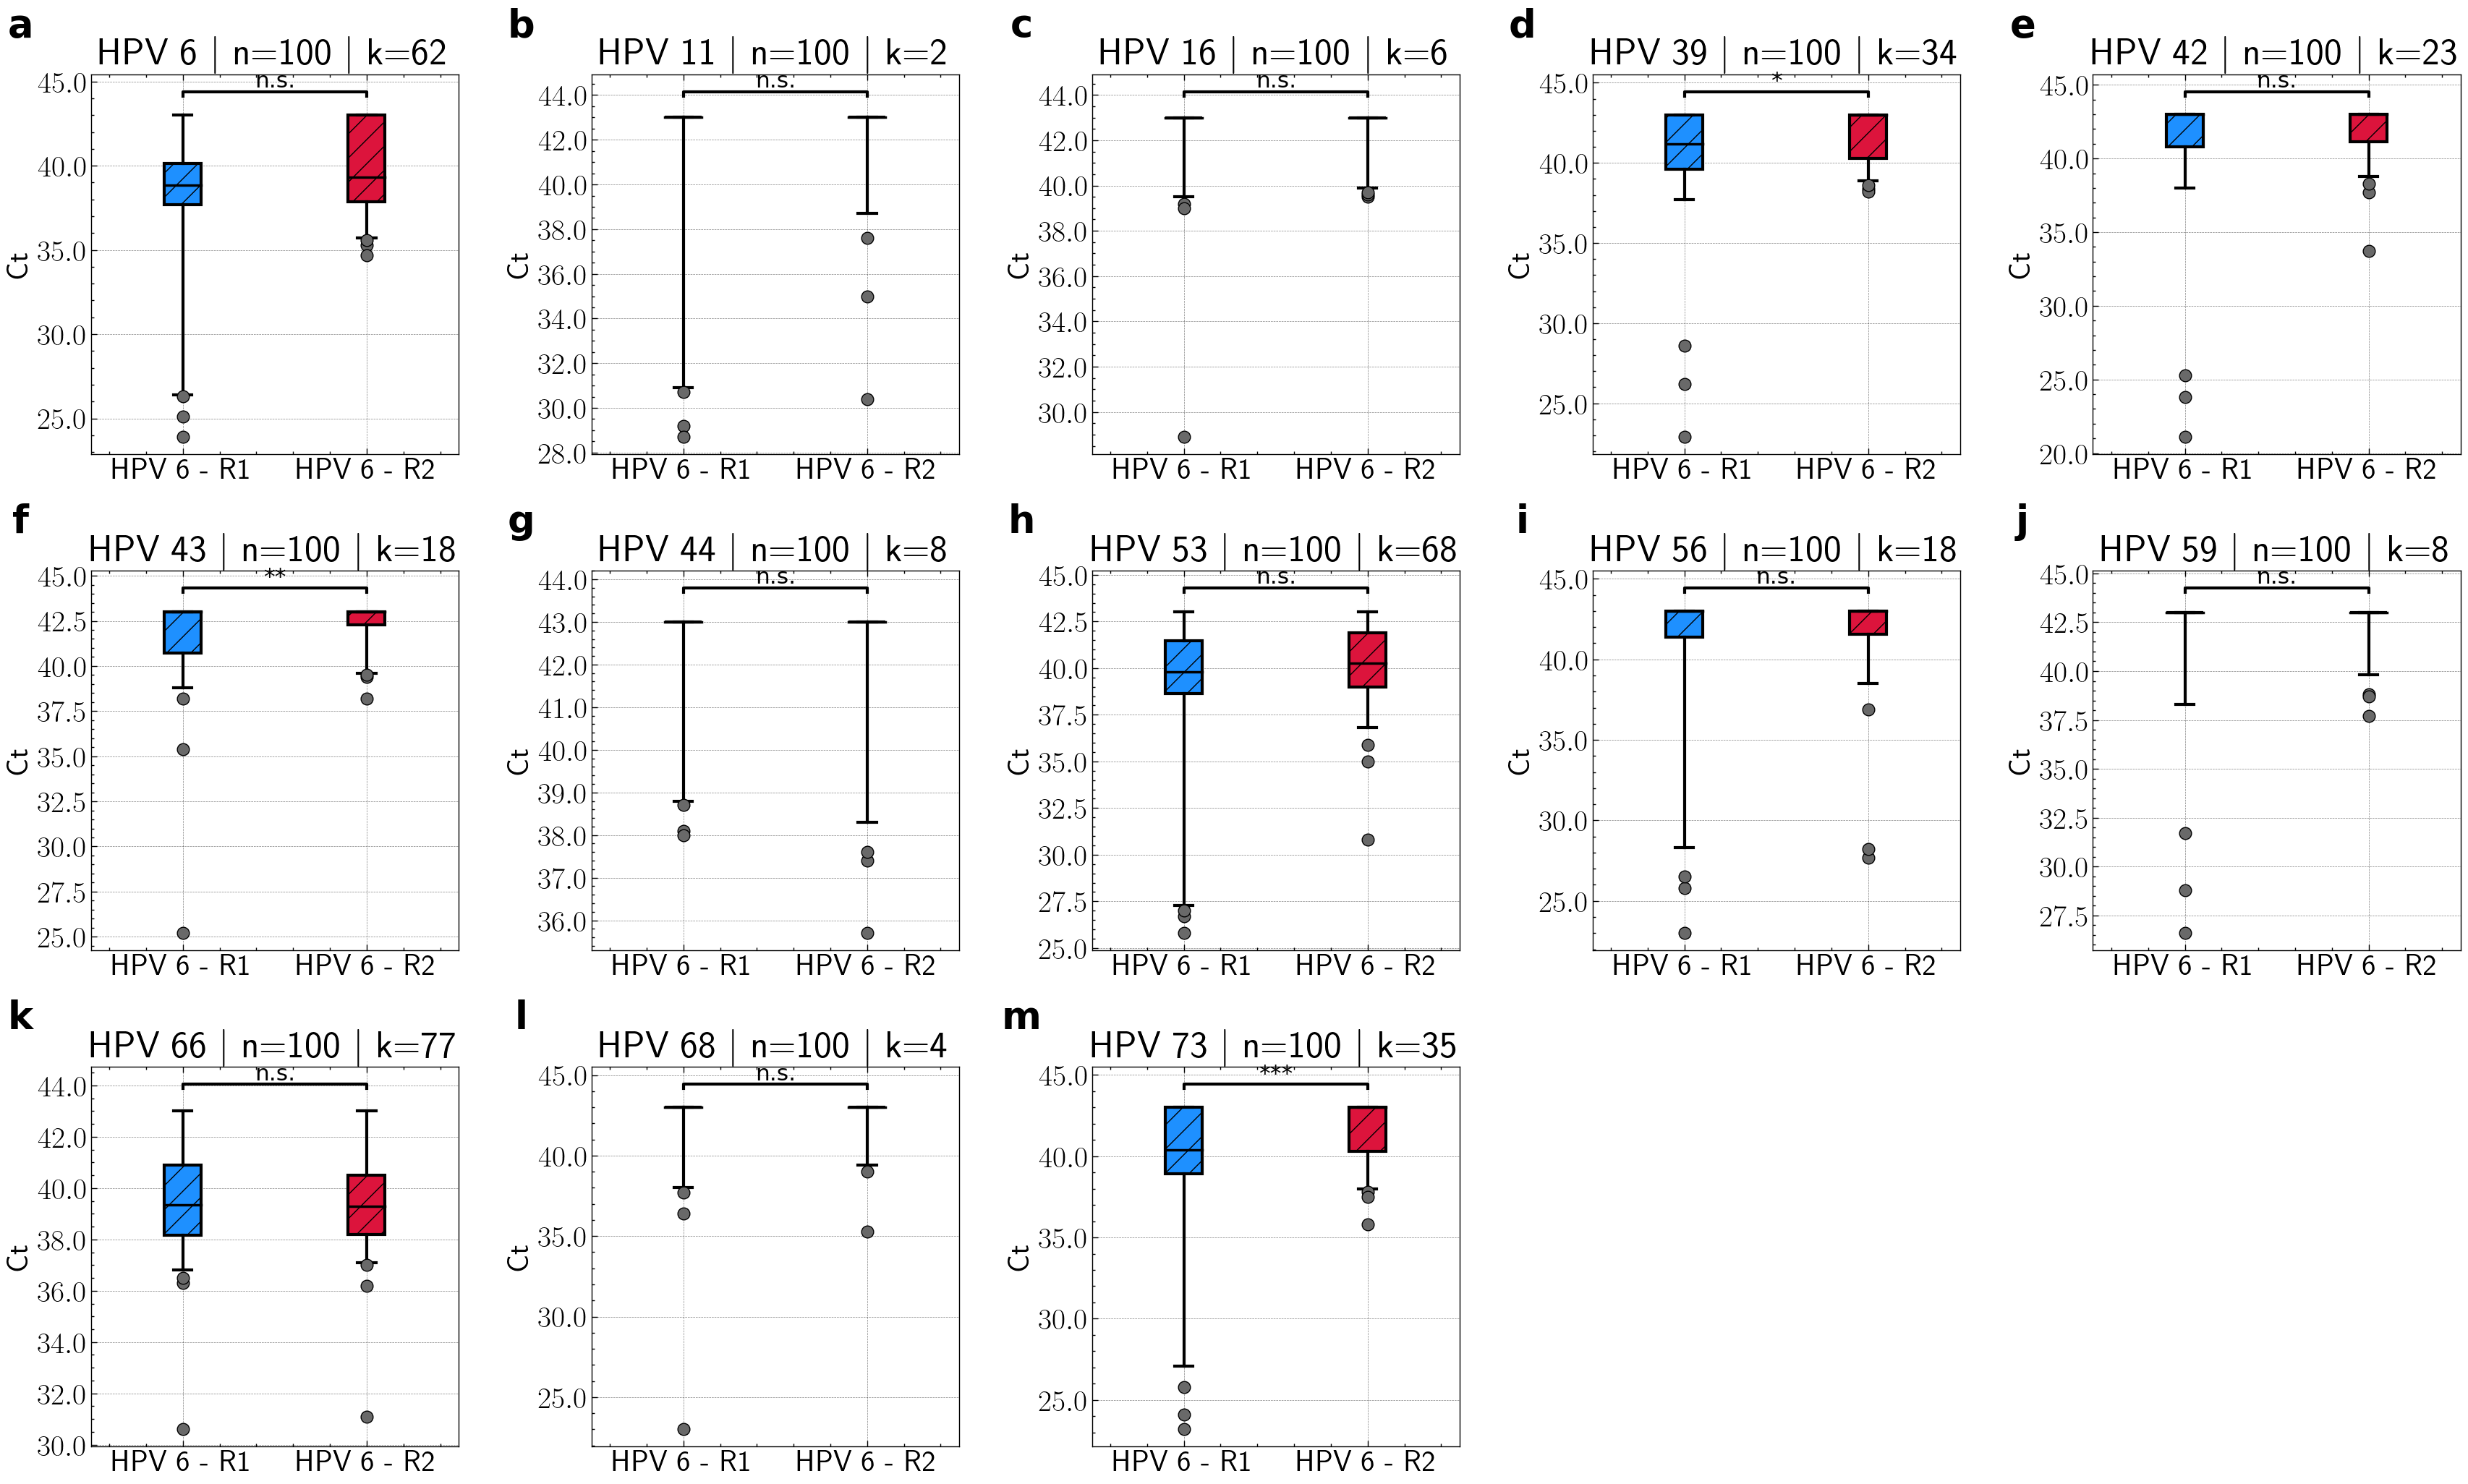

In [34]:
with plt.style.context(['science', 'notebook', 'grid']):

    KEY_SIZE = 38
    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (34, 20) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        ABCDE
        FGHIJ
        KLMNO
        """,
        gridspec_kw={'wspace': 0.1, 'hspace':0.1}
    )

    for this_letter in list(letter_type_dict.keys()):
        this_type = letter_type_dict[this_letter]
        sample_1, sample_2 = join_and_get_samples(this_type)

        # perform statistical testing only if a sufficient number of samples is available:
        if sample_1.shape[0] < 2 or sample_2.shape[0] < 0:
            continue

        toto = create_dataframe(this_type)
        toto_s1 = toto.Replicate_1.values
        cens_toto_s1 = toto.Replicate_1_cens.values
        toto_s2 = toto.Replicate_2.values
        cens_toto_s2 = toto.Replicate_2_cens.values

        full_sample_1 = toto_s1
        full_sample_2 = toto_s2
        
        symbol = symbols_dict[this_type]#compute_statistical_test(sample_1, sample_2)
        
        for sample_index, sample in enumerate([full_sample_1, full_sample_2]):
            plot_boxplots(this_letter, sample, sample_index, colors[sample_index], replicates[sample_index])

        plot_statistical_signficance(this_letter, symbol)

        this_k = str(toto.loc[(~toto.Replicate_1_cens)&(~toto.Replicate_2_cens)].shape[0])
        this_title = this_type + ' $|$ ' + 'n=100' + ' $|$ ' + 'k=' + this_k
        
        ax_dict[this_letter].set_title(this_title, size=TITLE_SIZE)

        # Specifying xlabels:
        plt.rcParams['text.usetex'] = True
        ax_dict[this_letter].set_xticks(np.arange(len(box_labels)))
        ax_dict[this_letter].set_xticklabels(box_labels, rotation=0)
    
        # Specifying ylabels:
        ax_dict[this_letter].set_ylabel(y_label)
    
        # Specifying y axis float definition:
        ax_dict[this_letter].yaxis.set_major_formatter(digit_y_label)
    
        ax_dict[this_letter].yaxis.tick_left()
        ax_dict[this_letter].yaxis.set_label_position('left')


    for this_letter in ['N', 'O']:
        ax_dict[this_letter].set_visible(False)

    # Main legend

    # Display subplot keys
    plt.rcParams['text.usetex'] = False
    fig.canvas.draw()

    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig, offset):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + offset, text.lower(), ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        if key not in ['N', 'O']:
            offset = .165
            align_text_with_ylabel(ax, key, fig, offset)

    plt.savefig("../outputs/figs/" + "replicates_comparison_full" + "2020-11-05" + ".pdf", bbox_inches = 'tight')

### mtDNA & crAssphages

In [35]:
ww_data_phages = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_crAssphages_standalone.csv', sep=";")
ww_data_phages.dateStart = pd.to_datetime(ww_data_phages.dateStart)

In [36]:
start_date, end_date = ww_data_phages.dateStart.tolist()[0], ww_data_phages.dateStart.tolist()[-1]

In [37]:
ww_data_mtDNA = pd.read_csv('../outputs/files/3010/HPV_HF_2025-10-30_mtDNA_standalone.csv', sep=";")
ww_data_mtDNA.dateStart = pd.to_datetime(ww_data_mtDNA.dateStart)

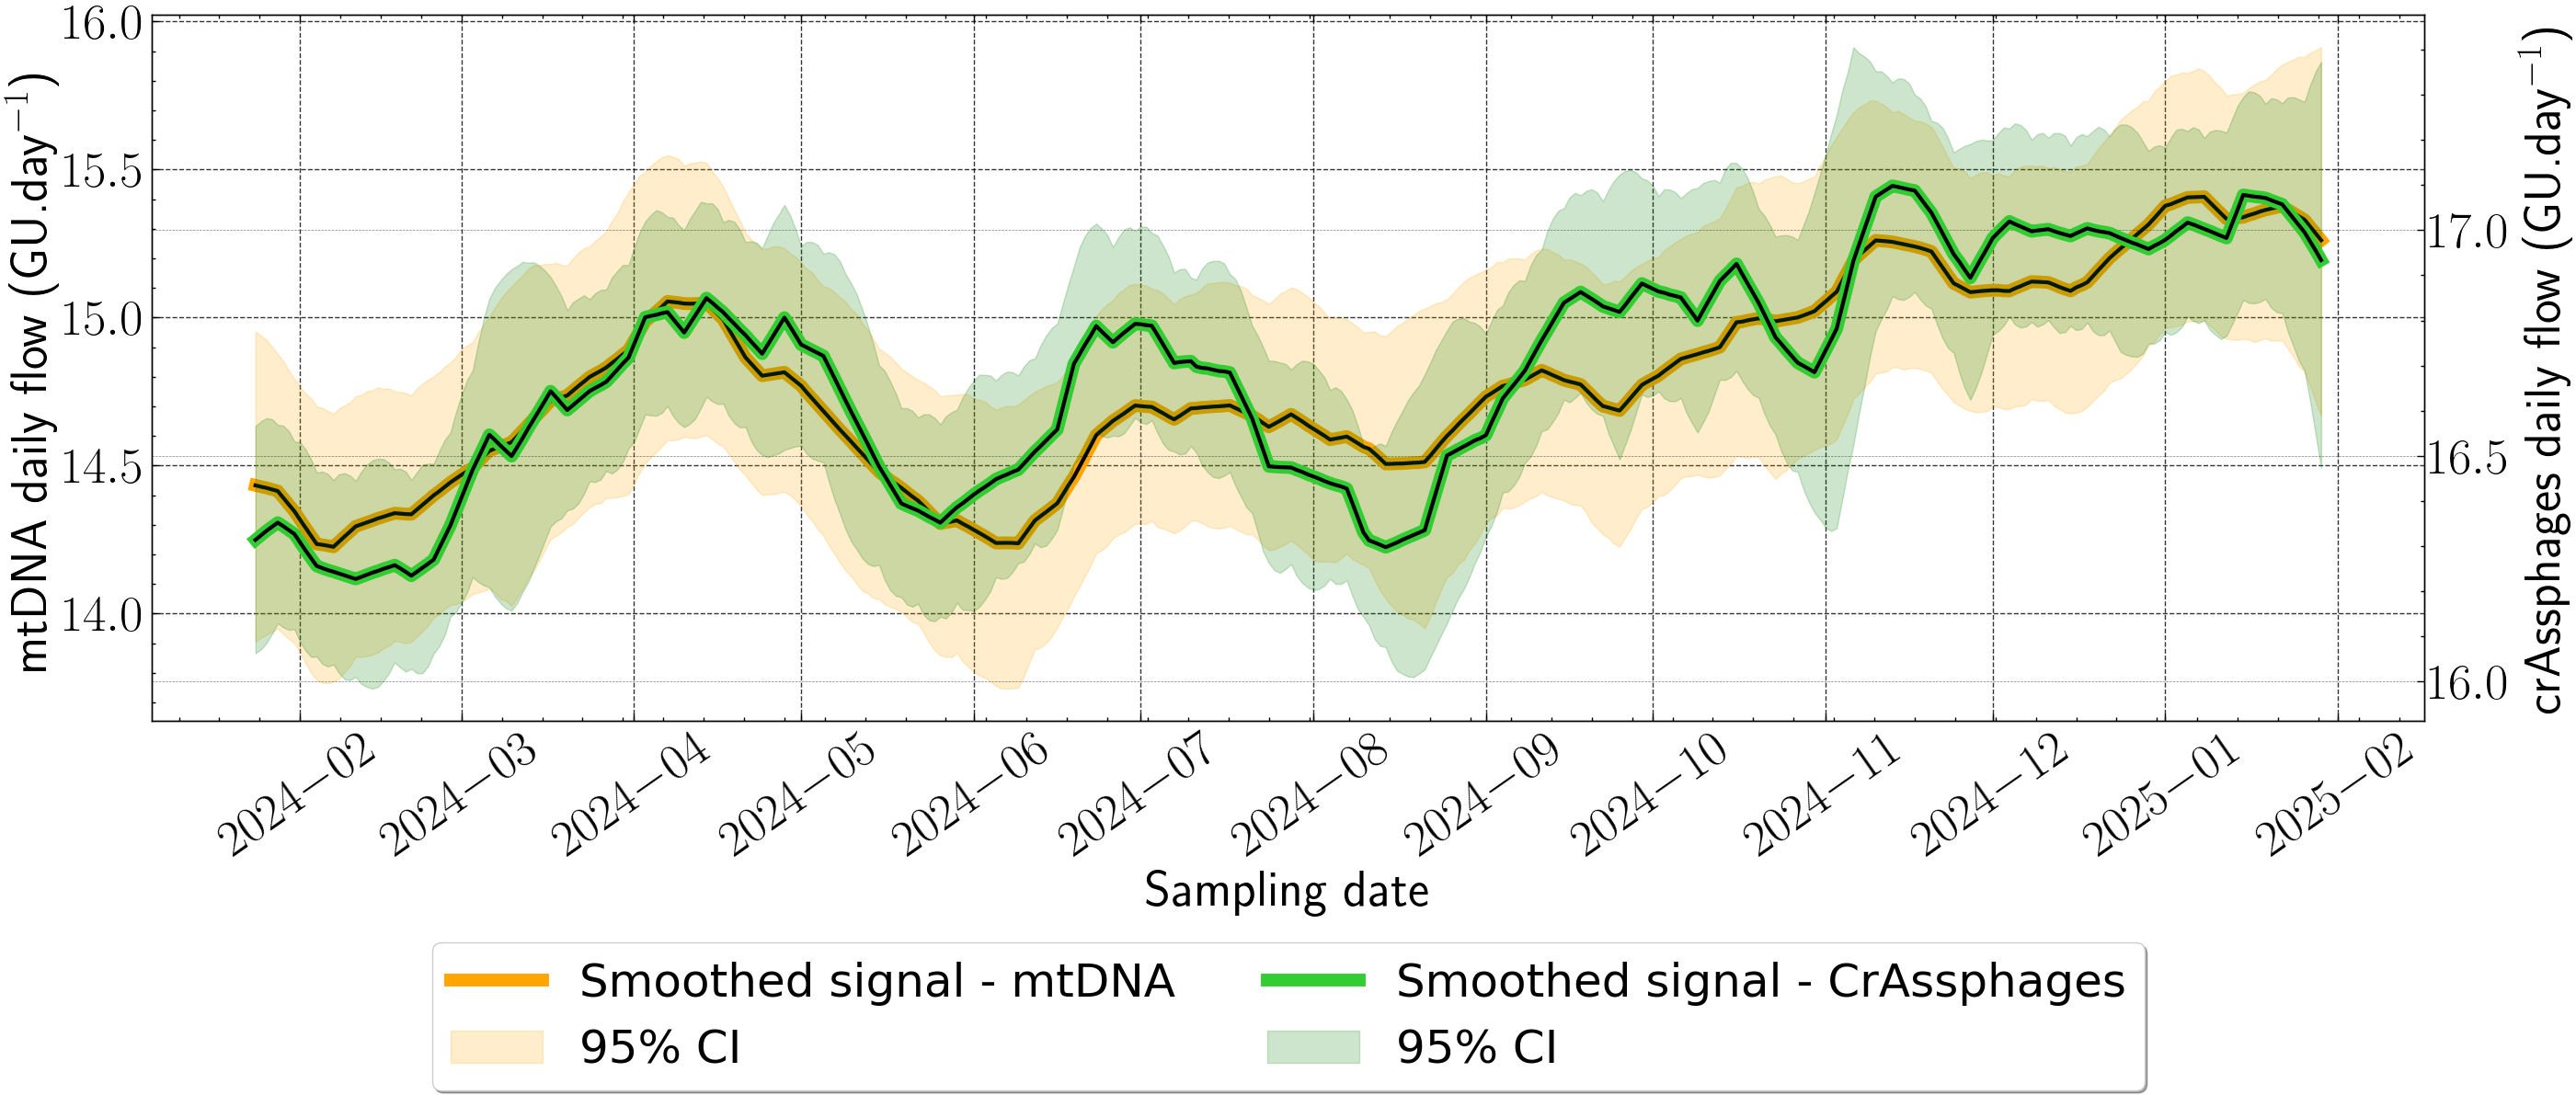

In [38]:
sub_data = ww_data_mtDNA.copy()
sub_data_2 = ww_data_phages.copy()

this_molecule = 'mtDNA_vs_crAssphages'

with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1.0#0.875
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (34, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='Smoothed signal - mtDNA', color='orange', linewidth=10, zorder=3)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, color='black', linewidth=3, zorder=3)

    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.2, color='orange', label='95% CI')

    ax_dict['A'].set_ylabel("mtDNA daily flow (GU.day$^{-1}$)")
    ax_dict['A'].set_xlabel("Sampling date")
    #ax_dict['A'].set_title('mtDNA \& crAssphages', size=TITLE_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)

    ax_cases = ax_dict['A'].twinx()
    ax_cases.plot(sub_data_2.dateStart.values, sub_data_2.muX.values, label='Smoothed signal - CrAssphages', color='limegreen', linewidth=10, zorder=3)
    ax_cases.plot(sub_data_2.dateStart.values, sub_data_2.muX.values, color='black', linewidth=3, zorder=3)

    ax_cases.fill_between(sub_data_2.dateStart.values, 
                          sub_data_2.ICL.values, 
                          sub_data_2.ICU.values, alpha=.2, color='green', label='95% CI')

    ax_cases.set_ylabel("crAssphages daily flow (GU.day$^{-1}$)")
    ax_cases.xaxis.set_major_locator(mdates.MonthLocator())
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE, rotation=35)
                        
    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    h2, l2 = ax_cases.get_legend_handles_labels()
    fig.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=2)
    #plt.savefig("../outputs/figs/" + this_molecule + ".pdf", bbox_inches = 'tight')
    #plt.savefig("../outputs/figs/" + 'Figure_2' + ".pdf", bbox_inches = 'tight')
    
    plt.show()

### Bootstrap

In [39]:
bfreq = pd.read_csv('../outputs/files/bootstrap_frequencies.csv', sep=';')
bfreq.set_index('HPV_type', inplace=True)
bfreq.head()

mean_frequency  frequency_CIL  frequency_CIU
HPV_type                                              
HPV66                 97           93.0          100.0
HPV6                  94           89.0           98.0
HPV53                 89           83.0           95.0
HPV39                 72           63.0           81.0
HPV73                 71           62.0           80.0

In [40]:
idx_bf = [el[:3] + ' ' + el[3:] for el in bfreq.index.tolist()]

In [41]:
bfreq.reset_index(inplace=True)
bfreq.head()

HPV_type  mean_frequency  frequency_CIL  frequency_CIU
0    HPV66              97           93.0          100.0
1     HPV6              94           89.0           98.0
2    HPV53              89           83.0           95.0
3    HPV39              72           63.0           81.0
4    HPV73              71           62.0           80.0

In [42]:
bfreq_weekly = pd.read_csv('../outputs/files/bootstrap_frequencies_weekly_2.csv', sep=';')
bfreq_weekly.set_index('HPV_type', inplace=True)
bfreq_weekly = bfreq_weekly.loc[idx_bf]
bfreq_weekly.reset_index(inplace=True)
bfreq_weekly.head()

HPV_type  mean_frequency  frequency_CIL  frequency_CIU
0   HPV 66          97.044           94.0          100.0
1    HPV 6          93.090           88.0           98.0
2   HPV 53          88.982           82.0           96.0
3   HPV 39          70.962           62.0           80.0
4   HPV 73          68.708           60.0           76.0

In [43]:
bfreq_monthly = pd.read_csv('../outputs/files/bootstrap_frequencies_monthly_2.csv', sep=';')
bfreq_monthly.set_index('HPV_type', inplace=True)
bfreq_monthly = bfreq_monthly.loc[idx_bf]
bfreq_monthly.reset_index(inplace=True)
bfreq_monthly.head()

HPV_type  mean_frequency  frequency_CIL  frequency_CIU
0   HPV 66       96.833333      83.333333     100.000000
1    HPV 6       92.558333      75.000000     100.000000
2   HPV 53       88.516667      66.666667     100.000000
3   HPV 39       70.633333      41.666667      91.666667
4   HPV 73       67.966667      41.666667      91.666667

In [44]:
bfreq_bimonthly = pd.read_csv('../outputs/files/bootstrap_frequencies_bimonthly_2.csv', sep=';')
bfreq_bimonthly.set_index('HPV_type', inplace=True)
bfreq_bimonthly = bfreq_bimonthly.loc[idx_bf]
bfreq_bimonthly.reset_index(inplace=True)
bfreq_bimonthly.head()

HPV_type  mean_frequency  frequency_CIL  frequency_CIU
0   HPV 66          96.828           92.0          100.0
1    HPV 6          92.996           84.0          100.0
2   HPV 53          88.984           76.0          100.0
3   HPV 39          71.352           56.0           88.0
4   HPV 73          68.744           52.0           84.0

In [45]:
colorz = ['dodgerblue', 'red', 'darkorange', 'forestgreen', 'limegreen', 'navy', 'black', 'teal',
         'gold', 'forestgreen', 'blueviolet', 'fuchsia',
         'deepskyblue', 'mediumturquoise', 'mediumorchid', 'coral', 'olive', 'silver', 
          'crimson', 'lightseagreen', 'goldenrod', 'brown', 'darkorchid', 'cornflowerblue',
          'black']

In [46]:
raw_data_bts_r1 = pd.read_excel('../data/HPV Seine Centre Paris resutats_PM-VM.xlsx', sheet_name='Ct par type HPV (réplicat 1)')
raw_data_bts_r1.drop_duplicates(subset='Date', inplace=True)

raw_data_bts_r2 = pd.read_excel('../data/HPV Seine Centre Paris resutats_PM-VM.xlsx', sheet_name='Ct par type HPV (réplicat 2)')
raw_data_bts_r2.drop_duplicates(subset='Date', inplace=True)

raw_data_bts = pd.concat((raw_data_bts_r1, raw_data_bts_r2))

In [47]:
toto = raw_data_bts.columns.tolist()

In [48]:
raw_data_bts.columns = [''.join(el.split(' ')) for el in toto]

In [49]:
mean_CT = []
for this_type in bfreq.HPV_type.tolist():
    those_CTs = raw_data_bts[this_type].values
    those_CTs[those_CTs == 'NA '] = np.nan
    those_CTs[those_CTs == ' NA'] = np.nan
    those_CTs = those_CTs.astype(float)
    this_mean_CT = np.nanmean(those_CTs)
    mean_CT.append(this_mean_CT)

/var/folders/y4/tbd21czj5954jkwdjwy02ct80000gp/T/ipykernel_16571/1510145630.py:7: RuntimeWarning: Mean of empty slice
  this_mean_CT = np.nanmean(those_CTs)


In [50]:
mean_CT = np.array(mean_CT)
mean_CT[np.isnan(mean_CT)] = 40 

In [51]:
bfreq['mean_CT'] = mean_CT
bfreq

HPV_type  mean_frequency  frequency_CIL  frequency_CIU    mean_CT
0     HPV66              97         93.000        100.000  39.096023
1      HPV6              94         89.000         98.000  37.951948
2     HPV53              89         83.000         95.000  38.980764
3     HPV39              72         63.000         81.000  39.713333
4     HPV73              71         62.000         80.000  38.818447
5     HPV42              60         50.000         70.000  39.905060
6     HPV56              58         48.000         68.000  39.472000
7     HPV43              54         43.975         64.000  40.439726
8     HPV68              31         23.000         40.000  39.079412
9     HPV59              26         18.000         34.025  39.945714
10    HPV44              23         14.975         32.000  39.338710
11    HPV11              21         13.000         30.000  36.578261
12    HPV16              19         12.000         27.000  40.215385
13    HPV54              14          8.000         21.000  38.721429
14    HPV40              13          7.000         20.000  38.023077
15    HPV45              11          6.000         18.000  40.400000
16    HPV35               8          3.000         14.000  40.211111
17    HPV69               7          2.000         12.000  36.785714
18    HPV70               6          2.000         11.000  39.000000
19    HPV82               5          1.000         10.000  28.060000
20    HPV26               5          1.000          9.000  36.300000
21    HPV33               5          1.000         10.000  34.550000
22    HPV18               4          1.000          8.000  35.000000
23    HPV31               3          0.000          7.000  34.875000
24    HPV51               3          0.000          7.000  34.100000
25    HPV52               2          0.000          5.000  41.250000
26    HPV58               2          0.000          5.000  41.500000
27    HPV61               0          0.000          0.000  40.000000

In [52]:
bfreq_weekly['mean_CT'] = mean_CT
bfreq_monthly['mean_CT'] = mean_CT
bfreq_bimonthly['mean_CT'] = mean_CT

In [53]:
values = bfreq.mean_CT.values
norm = Normalize(vmin=values.min(), vmax=values.max())
colors = cm.bwr(norm(values))
colors = cm.bwr(Normalize()(values))
colors = cm.winter(norm(values))
sm = cm.ScalarMappable(cmap=cm.winter, norm=norm)
sm.set_array([])

In [54]:
values = bfreq.mean_frequency.values

lower_ci = bfreq.frequency_CIL.values 
upper_ci = bfreq.frequency_CIU.values 

yerr_lower = values - lower_ci
yerr_upper = upper_ci - values
yerr = [yerr_lower, yerr_upper]  

In [55]:
bfreq_letter_dict = {}
bfreq_letter_dict['A'] = bfreq
bfreq_letter_dict['B'] = bfreq_weekly
bfreq_letter_dict['C'] = bfreq_bimonthly
bfreq_letter_dict['D'] = bfreq_monthly

In [56]:
letter_title_dict = {}
letter_title_dict['A'] = 'Original sampling' + ' $|$ ' + 'n=100'
letter_title_dict['B'] = 'Weekly subsampling' + ' $|$ ' + 'n=50'
letter_title_dict['C'] = 'Bimonthly sampling' + ' $|$ ' + 'n=25'
letter_title_dict['D'] = 'Monthly sampling' + ' $|$ ' + 'n=12'

In [58]:
def compute_and_plot(bfreq_df, this_letter, title):

    # error bar computations:
    values = bfreq_df.mean_frequency.values
    lower_ci = bfreq_df.frequency_CIL.values 
    upper_ci = bfreq_df.frequency_CIU.values
    
    yerr_lower = values - lower_ci
    yerr_upper = upper_ci - values
    yerr = [yerr_lower, yerr_upper] 

    ax_dict[this_letter].bar(np.arange(bfreq_df.shape[0]), bfreq_df.mean_frequency.values, 
                     color=colors, edgecolor='black', linewidth=5)
    ax_dict[this_letter].set_xticks(np.arange(bfreq_df.shape[0]))
    ax_dict[this_letter].set_xticklabels(bfreq_df.HPV_type.values, rotation=90)

    # plotting error bars:
    ax_dict[this_letter].errorbar(np.arange(bfreq_df.shape[0]), values, 
                          yerr=yerr, 
                          fmt='none',  
                          ecolor='black', 
                          elinewidth=3,
                          capsize=10,
                          capthick=4)

    ax_dict[this_letter].set_ylabel("Detection frequency (\%)")
    ax_dict[this_letter].set_title(title, size=TITLE_SIZE)

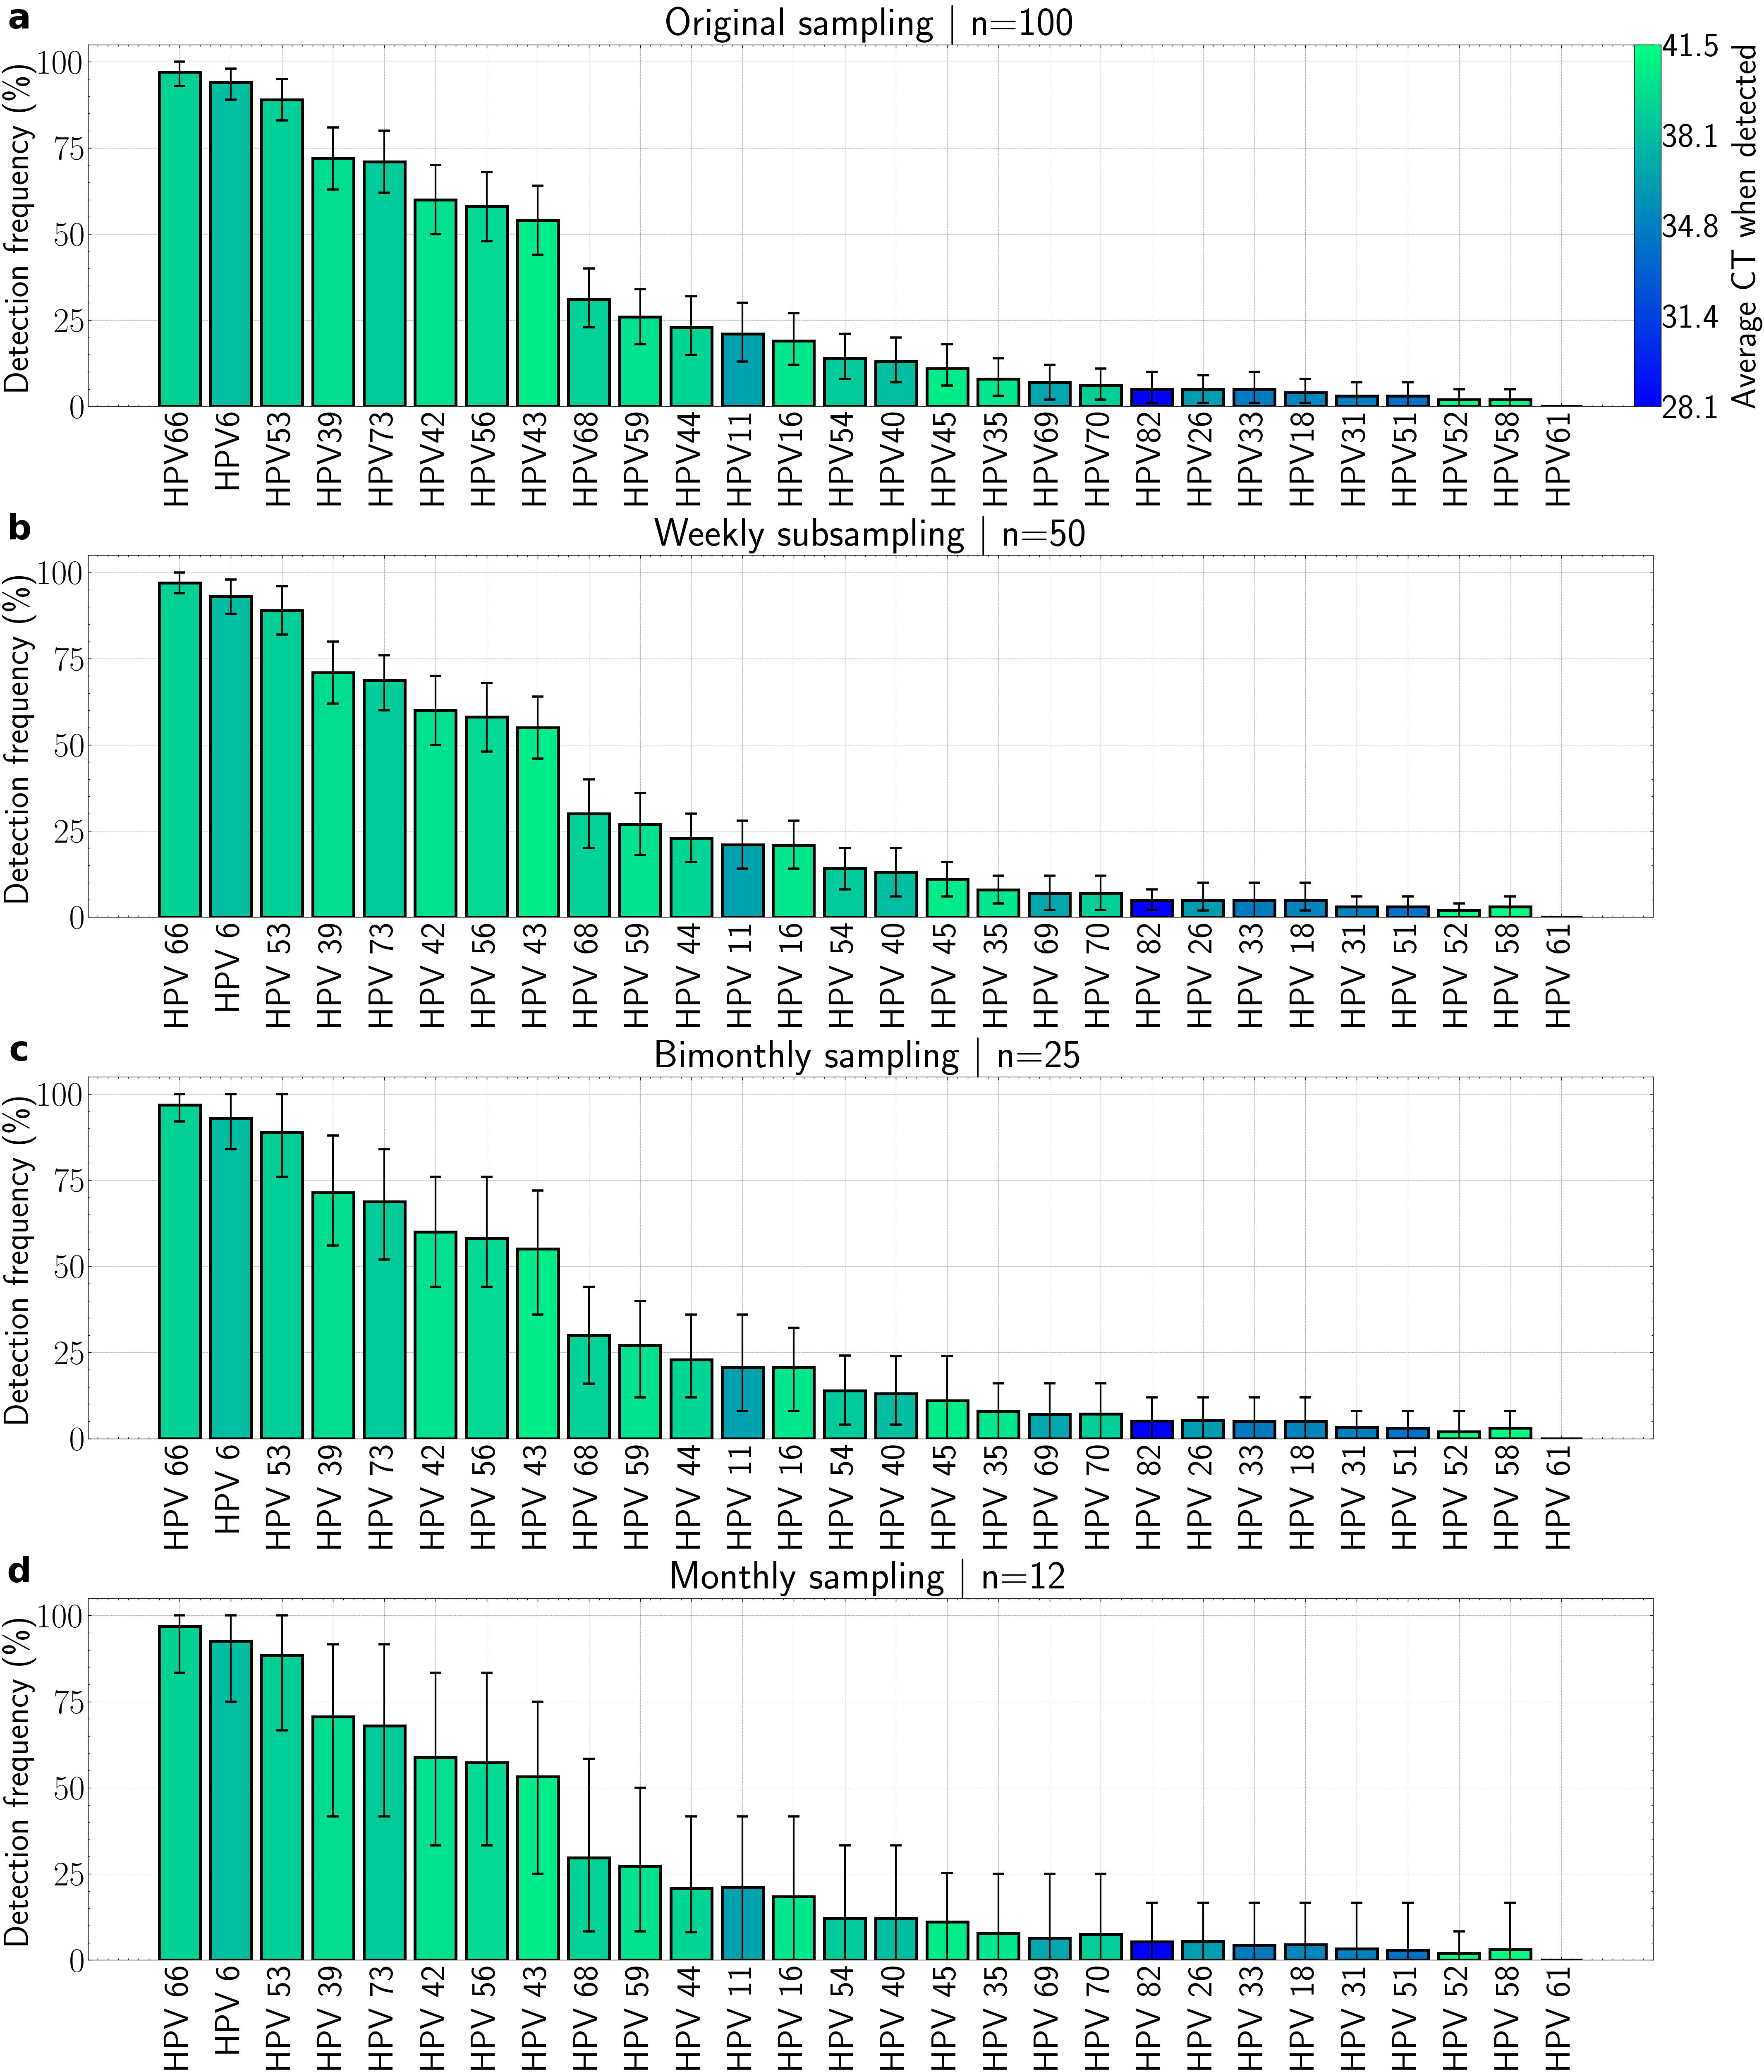

In [59]:
with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1.5
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (40, 50) 
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        B
        C
        D
        """
    )

    for this_letter in ['A', 'B', 'C', 'D']:
        compute_and_plot(bfreq_letter_dict[this_letter], this_letter, letter_title_dict[this_letter])

    ### Outlier probability legend:
    cmin, cmax = np.min(bfreq.mean_CT.values), np.max(bfreq.mean_CT.values)
    axins1 = inset_axes(ax_dict['A'], width='85%', height='100%', 
                        bbox_to_anchor=(1.075-0.09, 0, 0.02, 1), 
                        bbox_transform=ax_dict['A'].transAxes, 
                        borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(sm, cax=axins1, orientation='vertical')

    custom_ticks = np.linspace(cmin, cmax, num=5)
    cbar.set_ticks(custom_ticks)

    ref_label = ax_dict['A'].get_yticklabels()[0] 
    font_props = ref_label.get_fontproperties()
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{val:.{decimal_places}f}" for val in custom_ticks], fontsize=TICK_SIZE, fontproperties=font_props)
                        
    
    # Placing the label at the right spot - ajustez le labelpad pour la droite
    cbar.ax.set_ylabel('Average CT when detected', size=TICK_SIZE, labelpad=20)

    # Display subplot keys
    plt.rcParams['text.usetex'] = False
    fig.canvas.draw()
    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig, offset):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + offset, text.lower(), ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        offset = .1
        align_text_with_ylabel(ax, key, fig, offset)
    
    plt.savefig("../outputs/figs/" + 'bootstrap_frequencies_manuscript' + '2026-01-09' + ".pdf", bbox_inches = 'tight')
    
    plt.show()